In [1]:
import sys
sys.path.insert(0, "/cndd/fangming/CEMBA/snmcseq_dev")

from multiprocessing import Pool,cpu_count
from functools import partial

from scipy import sparse
from scipy import stats
from scipy import optimize
import importlib
from __init__ import *
from __init__jupyterlab import *
import snmcseq_utils
importlib.reload(snmcseq_utils)

import re
import pickle
import datetime
from scipy import optimize

import tqdm

import importlib
sys.path.insert(0, '../')
import enhancer_gene_utils
importlib.reload(enhancer_gene_utils)
from enhancer_gene_utils import get_corr_stats



In [2]:
today = datetime.date.today()
print(today)

2020-12-11


# Plot mC, ATAC, both (one knn, different metacells)
### - 80% cells for 5-time downsampling

In [3]:
input_enh_gene_table = '/cndd2/fangming/projects/scf_enhancers/results/200521_to_evals.tsv' 
output_figures = '/cndd2/fangming/projects/scf_enhancers/results/figures/{}_metacell_corr_res_{{}}.pdf'.format(today)

In [4]:
# enhancer-gene linkage
ti = time.time()
enhancer_gene_to_eval = (pd.read_csv(input_enh_gene_table, sep='\t')
                             [['gene', 'ens', 'dist']]
                             .rename(columns={'ens': 'enh'})
                        )

print(enhancer_gene_to_eval.shape)
print(time.time()-ti)
enhancer_gene_to_eval.head()

(2589994, 3)
5.797335147857666


gene     enh    dist
0  ENSMUSG00000000001  147520  995118
1  ENSMUSG00000000001  147522  985740
2  ENSMUSG00000000001  147523  983725
3  ENSMUSG00000000001  147527  970444
4  ENSMUSG00000000001  147528  969372

In [5]:
# get all clusterings
def get_isub_clstfile(fname):
    """Subsampling index
    """
    pattern = '_sub[0-9]+.tsv.gz' 
    isub = int(re.findall(pattern, fname)[0][len("_sub"):-len('.tsv.gz')])
    return isub 

def get_knn_clstfile(fname):
    """cross-modal knn
    """
    pattern = '_knn[0-9]+_' 
    knn = int(re.findall(pattern, fname)[0][len("_knn"):-len('_')])
    return knn 

f_pattern = ("/cndd2/fangming/projects/miniatlas/results/"
             "clusterings_10x_cells_v3_mop_10x_cells_v3_snatac_gene_ka30_knn*_201206_sub*.tsv.gz"
             )
fnames = np.sort(glob.glob(f_pattern))
iterator_clsts = pd.DataFrame([{'i': get_isub_clstfile(fname),
                                'k': get_knn_clstfile(fname),
                                'fname': fname,
                              } for fname in fnames])
print(iterator_clsts.shape)

res_clsts = []
for idx, row in tqdm.tqdm(iterator_clsts.iterrows()):
    isub = row['i']
    knn = row['k']
    fname = row['fname']
    
    df = pd.read_csv(fname, index_col=0, sep='\t')
    for col in df.columns:
        r = float(col[len('cluster_r'):])
        num_clst = len(df[col].unique())
        res_clsts.append({
            'k': knn,
            'i': isub,
            'r': r,
            'num_clst': num_clst,
        })
#     break
res_clsts = pd.DataFrame(res_clsts)

print(res_clsts.shape)
res_clsts.head()

0it [00:00, ?it/s]

(1, 3)


1it [00:00,  2.01it/s]

(41, 4)


k  i         r  num_clst
0  30  0  1.000000        16
1  30  0  1.258925        18
2  30  0  1.584893        22
3  30  0  1.995262        28
4  30  0  2.511886        34

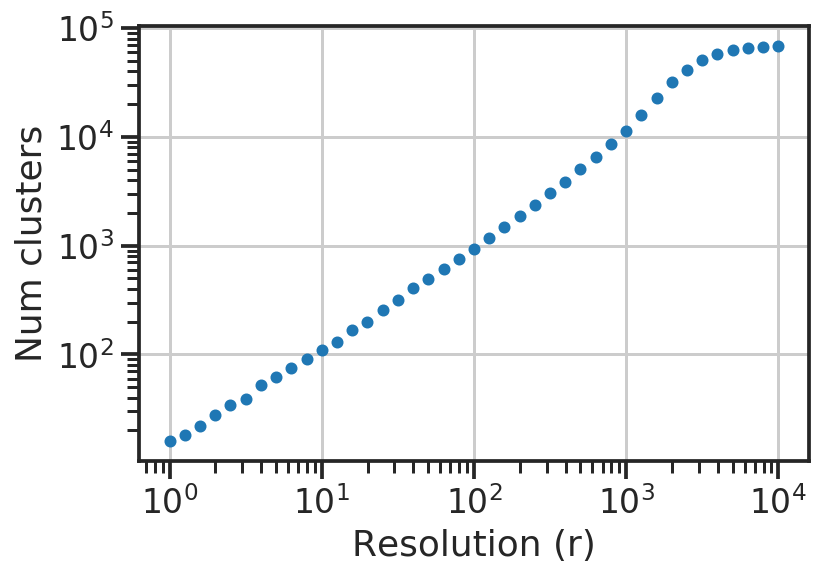

In [6]:
fig, ax = plt.subplots()
ax.plot(res_clsts['r'].values, res_clsts['num_clst'].values, 'o', markersize=5)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Resolution (r)')
ax.set_ylabel('Num clusters')
plt.show()

In [7]:
bins = np.linspace(-1,1,201)
fdr_threshold = 0.2
distance_threshold = 1e5
label = 'pairs (<100kb)'

col_orders = [
            'num_linked_pairs',
            'num_linked_genes',
            'num_linked_enhs',
            'id_linked_pairs',
    
            'num_correlated_pairs',
            'num_correlated_genes',
            'num_correlated_enhs',
            'id_correlated_pairs',
    
            'num_total_pairs',
            'num_total_genes',
            'num_total_enhs',
            'id_total_pairs',
    ]

In [8]:
# get all (shared) corr analyses
def get_resolution(fname):
    """Resolution
    """
    resolution_pattern = '_cluster_r[0-9.]+_' 
    r = float(re.findall(resolution_pattern, fname)[0][len("_cluster_r"):-len('_')])
    return r
    
def get_isub(fname):
    """Subsampling index
    """
    pattern = '_[0-9]_cluster' 
    isub = int(re.findall(pattern, fname)[0][len("_"):-len('_cluster')])
    return isub 

def get_knn(fname):
    """cross-modal knn
    """
    pattern = '_knn[0-9]+_' 
    knn = int(re.findall(pattern, fname)[0][len("_knn"):-len('_')])
    return knn 

# mC
f_pattern = ("/cndd2/fangming/projects/scf_enhancers/results/"
             "mop_10x_cells_v3_snmcseq_gene_ka30_knn*_201206"
             "_[0-9]_cluster_r*_spearmanr_corrs.pkl"
            )
fnames = np.sort(glob.glob(f_pattern))
iterator_mc = pd.DataFrame([{'r': get_resolution(fname),
                             'i': get_isub(fname),
                             'k': get_knn(fname),
                             'fname_mc': fname,
                          } for fname in fnames])
print(iterator_mc.shape)

# ATAC
f_pattern = ("/cndd2/fangming/projects/scf_enhancers/results/"
             "mop_10x_cells_v3_snatac_gene_ka30_knn*_201206"
             "_[0-9]_cluster_r*_spearmanr_corrs.pkl"
            )
fnames = np.sort(glob.glob(f_pattern))
iterator_atac = pd.DataFrame([{'r': get_resolution(fname),
                               'i': get_isub(fname),
                               'k': get_knn(fname),
                               'fname_atac': fname,
                              } for fname in fnames])
print(iterator_atac.shape)

# both
iterator_both = pd.merge(iterator_mc, iterator_atac, on=['k', 'r', 'i'])
print(iterator_both.shape)
iterator_both.head()

(30, 4)
(21, 4)
(21, 5)


r  i   k                                           fname_mc  \
0   1.000000  0  30  /cndd2/fangming/projects/scf_enhancers/results...   
1   1.258925  0  30  /cndd2/fangming/projects/scf_enhancers/results...   
2   1.584893  0  30  /cndd2/fangming/projects/scf_enhancers/results...   
3   1.995262  0  30  /cndd2/fangming/projects/scf_enhancers/results...   
4  10.000000  0  30  /cndd2/fangming/projects/scf_enhancers/results...   

                                          fname_atac  
0  /cndd2/fangming/projects/scf_enhancers/results...  
1  /cndd2/fangming/projects/scf_enhancers/results...  
2  /cndd2/fangming/projects/scf_enhancers/results...  
3  /cndd2/fangming/projects/scf_enhancers/results...  
4  /cndd2/fangming/projects/scf_enhancers/results...

In [9]:
# calc corr
iterator_both = iterator_both.sort_values(['r', 'i'])
res_corr = enhancer_gene_utils.get_corr_stats(iterator_both, enhancer_gene_to_eval, col_orders) 
iterator_both = iterator_both.join(res_corr)

21it [00:23,  1.12s/it]

(21, 30)


## specific ensemble to plot
- why nan in number of linked genes? (ATAC and mC)

In [10]:
knn = 30 

iterator_toplot = iterator_both[iterator_both['k']==knn]
print(iterator_toplot.shape)

# get number of unique clusters
iterator_toplot = pd.merge(iterator_toplot, res_clsts, on=['k', 'r', 'i'], how='inner')
print(iterator_toplot.shape)
iterator_toplot.head()

(21, 35)
(21, 36)


r  i   k                                           fname_mc  \
0  1.000000  0  30  /cndd2/fangming/projects/scf_enhancers/results...   
1  1.258925  0  30  /cndd2/fangming/projects/scf_enhancers/results...   
2  1.584893  0  30  /cndd2/fangming/projects/scf_enhancers/results...   
3  1.995262  0  30  /cndd2/fangming/projects/scf_enhancers/results...   
4  2.511886  0  30  /cndd2/fangming/projects/scf_enhancers/results...   

                                          fname_atac  num_linked_pairs_mc  \
0  /cndd2/fangming/projects/scf_enhancers/results...                 5137   
1  /cndd2/fangming/projects/scf_enhancers/results...                 6794   
2  /cndd2/fangming/projects/scf_enhancers/results...                 7447   
3  /cndd2/fangming/projects/scf_enhancers/results...                 9341   
4  /cndd2/fangming/projects/scf_enhancers/results...                 9429   

   num_linked_genes_mc  num_linked_enhs_mc  \
0                 1735                4726   
1                 1948                6181   
2                 1990                6788   
3                 2356                8433   
4                 2204                8553   

                                  id_linked_pairs_mc  num_correlated_pairs_mc  \
0  [481, 487, 489, 497, 499, 698, 1540, 1542, 154...                    79279   
1  [475, 481, 487, 497, 698, 1389, 1539, 1540, 15...                    84873   
2  [487, 489, 497, 697, 698, 1539, 1540, 1541, 15...                    92347   
3  [474, 475, 481, 485, 487, 488, 489, 495, 496, ...                    71921   
4  [474, 475, 481, 487, 489, 497, 499, 697, 698, ...                    94561   

   ...  num_total_genes_atac  num_total_enhs_atac  \
0  ...                 16157                95613   
1  ...                 16157                95613   
2  ...                 16157                95613   
3  ...                 16157                95613   
4  ...                 16157                95613   

                                 id_total_pairs_atac  num_linked_pairs_both  \
0  [94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 1...                    225   
1  [94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 1...                    226   
2  [94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 1...                    956   
3  [94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 1...                   1870   
4  [94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 1...                   2642   

   num_linked_genes_both  num_linked_enhs_both num_total_pairs_both  \
0                    170                   224               219162   
1                    171                   223               219132   
2                    507                   918               218992   
3                    814                  1772               219100   
4                   1001                  2475               219212   

   num_total_genes_both  num_total_enhs_both  num_clst  
0                 16149                95324        16  
1                 16147                95309        18  
2                 16142                95250        22  
3                 16150                95299        28  
4                 16150                95347        34  

[5 rows x 36 columns]

In [11]:
# for a fixed k, groupby r (collapsing i)

res_mean = iterator_toplot.groupby(['r']).mean().reset_index()
res_std = iterator_toplot.groupby(['r']).std().reset_index().fillna(0)
print(res_mean.shape, res_std.shape)
res_mean.tail()

(21, 28) (21, 28)


r  i   k  num_linked_pairs_mc  num_linked_genes_mc  \
16   39.810717  0  30                12515                 2538   
17   50.118723  0  30                11728                 2374   
18   63.095734  0  30                12609                 2499   
19   79.432823  0  30                12683                 2458   
20  100.000000  0  30                12556                 2411   

    num_linked_enhs_mc  num_correlated_pairs_mc  num_correlated_genes_mc  \
16               11492                   118701                    14536   
17               10846                   117272                    14419   
18               11645                   122042                    14650   
19               11737                   126027                    14851   
20               11669                   118723                    14500   

    num_correlated_enhs_mc  num_total_pairs_mc  ...  num_total_pairs_atac  \
16                   70224              219036  ...                219808   
17                   69526              219000  ...                219808   
18                   71207              218988  ...                219808   
19                   72524              218938  ...                219808   
20                   69966              218896  ...                219808   

    num_total_genes_atac  num_total_enhs_atac  num_linked_pairs_both  \
16                 16157                95613                   4618   
17                 16157                95613                   4808   
18                 16157                95613                   4929   
19                 16157                95613                   5305   
20                 16157                95613                   5248   

    num_linked_genes_both  num_linked_enhs_both  num_total_pairs_both  \
16                   1341                  4357                219036   
17                   1356                  4540                219000   
18                   1381                  4654                218988   
19                   1442                  5004                218938   
20                   1400                  4966                218896   

    num_total_genes_both  num_total_enhs_both  num_clst  
16                 16143                95281       405  
17                 16142                95258       494  
18                 16142                95250       607  
19                 16141                95231       760  
20                 16141                95213       935  

[5 rows x 28 columns]

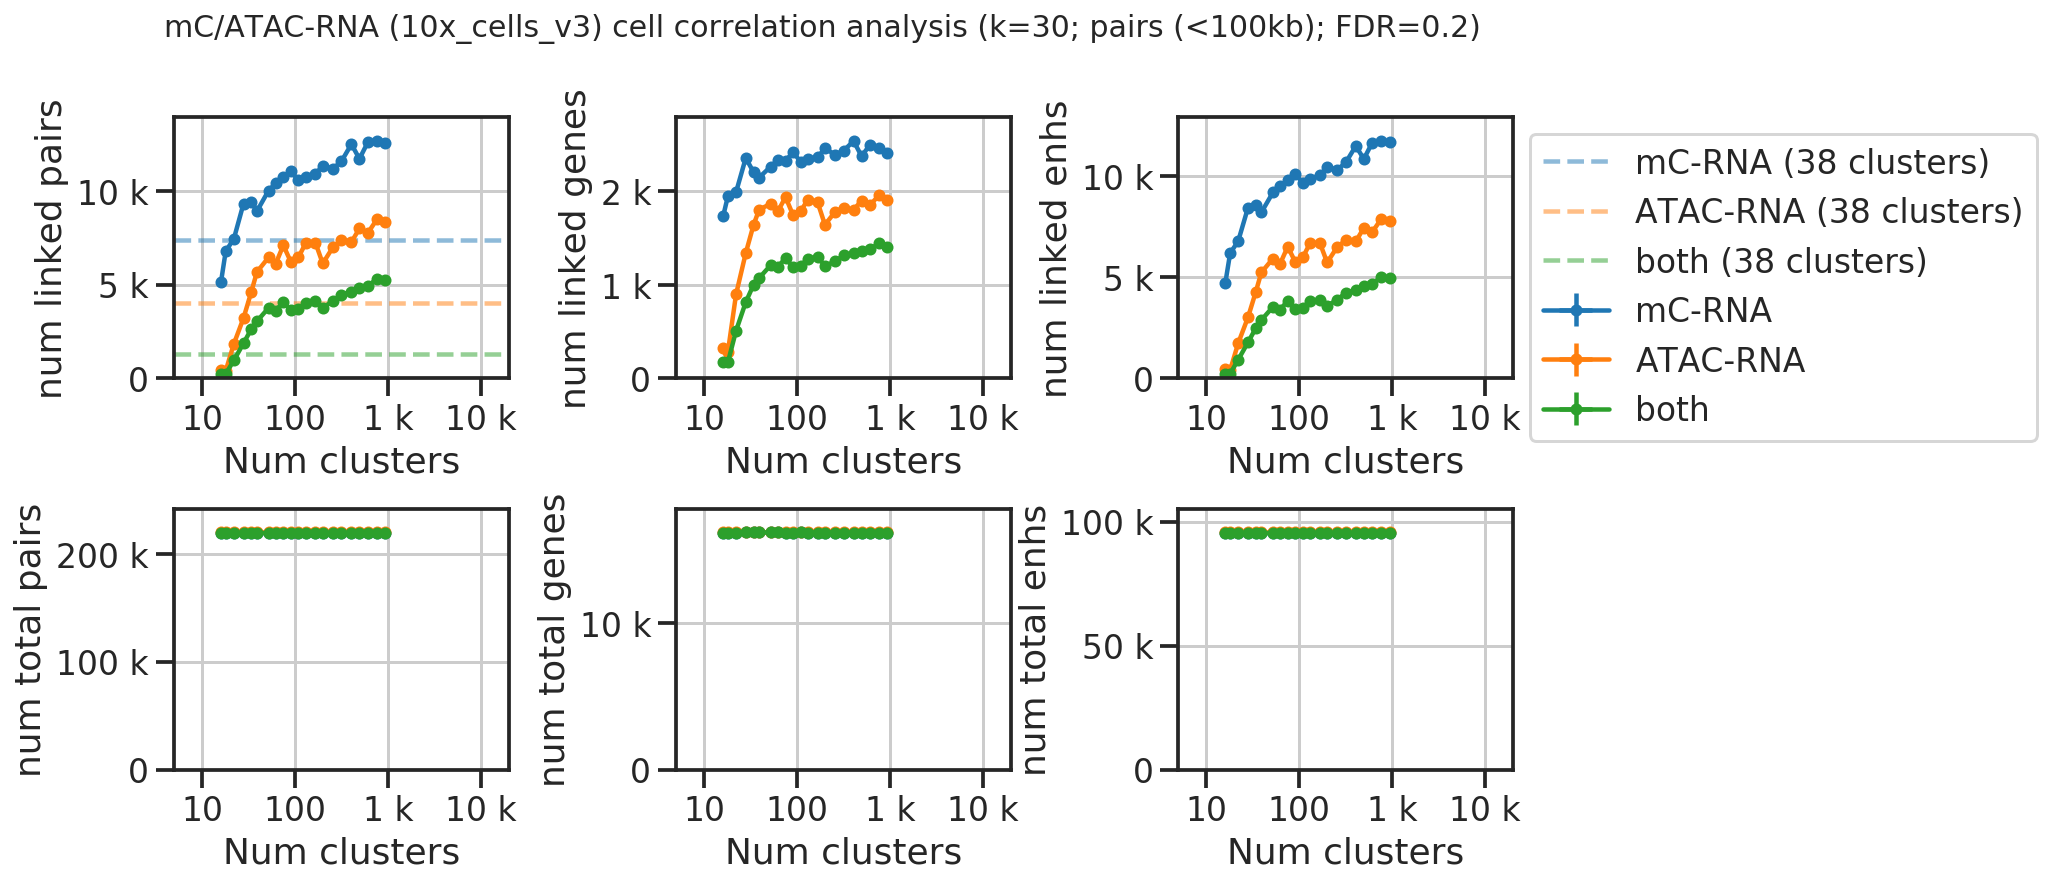

In [12]:
plot_cols = [
    'num_linked_pairs',
    'num_linked_genes',
    'num_linked_enhs',
    
    'num_total_pairs',
    'num_total_genes',
    'num_total_enhs',
]

# plot same ks

_table = res_mean
_table_std = res_std

mc_baseline = 6094+1300
atac_baseline = 2700+1300
both_baseline = 1300

fig, axs = plt.subplots(2, 3, figsize=(4*3, 3*2))
fig.suptitle('mC/ATAC-RNA (10x_cells_v3) cell correlation analysis (k={}; {}; FDR={})'.format(knn, label, fdr_threshold), 
             fontsize=15, y=1)
for i_ax, (ax, col) in enumerate(zip(axs.flat, plot_cols)):
    ymax = 0
    for _suffix, _type in zip(['_mc', '_atac', '_both'], 
                              ['mC-RNA', 'ATAC-RNA', 'both'],
                             ):
        _x = _table['num_clst']
        _x_std = _table_std['num_clst']
        _y = _table[col+_suffix]
        _y_std = _table_std[col+_suffix] 
        
        ax.errorbar(_x, _y, yerr=_y_std, xerr=_x_std.values, 
                    fmt='-o', 
                    markersize=5, 
                    label=_type)
        
        ymax = np.max([ymax, np.max(_y)])
    
    if i_ax == 0:
        ax.axhline(mc_baseline, color='C0', linestyle='--', alpha=0.5, label='mC-RNA (38 clusters)')
        ax.axhline(atac_baseline, color='C1', linestyle='--', alpha=0.5, label='ATAC-RNA (38 clusters)')
        ax.axhline(both_baseline, color='C2', linestyle='--', alpha=0.5, label='both (38 clusters)')
        ymax = max(ymax, mc_baseline, atac_baseline, both_baseline)
        
    ax.set_xscale('log')
    ax.set_xlim([5, 20000])
    ax.set_xticks([10, 100, 1000, 10000])
    ax.set_ylim(ymin=0, ymax=1.1*ymax)
    ax.set_ylabel(col.replace('_', ' '))

    ax.xaxis.set_major_formatter(mtick.EngFormatter())
    ax.yaxis.set_major_formatter(mtick.EngFormatter())
    ax.set_xlabel('Num clusters')
        
handles, labels = axs.flat[0].get_legend_handles_labels()
axs.flat[2].legend(handles, labels, bbox_to_anchor=(1,1), loc='upper left')
fig.subplots_adjust(wspace=0.5, hspace=0.5)
snmcseq_utils.savefig(fig, output_figures.format('p1_k{}'.format(knn)))
plt.show()

## Plot out one ATAC example distribution 

In [13]:
def prep_plot_dist_both(
    res_corrs, res2_corrs, 
    res_stats, res2_stats,
    colors_mc, colors_atac, colors_null, 
    ATAC_SIGN=-1,
    ):
    """
    """

    labels_base = [
              'shuffled cell types',
              'shuffled regions',
              '<500kb',
              '<100kb',
             ] 
    subsample_rates = [
                      1,
                      1,
                      1,
                      1,
                     ]

    # corr1
    labels = [label+' mCG-RNA' for label in labels_base]
    corr_tracks = [
           res_corrs['corr_shuff_cells'].values,
           res_corrs['corr_shuff'].values,
           res_corrs.loc[res_corrs['dist']<=500*KB, 'corr'].values,
           res_corrs.loc[res_corrs['dist']<=100*KB, 'corr'].values,
          ]
    colors = [colors_null[1], colors_null[0], colors_mc[1], colors_mc[0],]
    vertical_lines = [
        res_stats['r_th_linked'],
        res_stats['r_th_correlated_left'],
        res_stats['r_th_correlated_right'],
    ]

    # corr2
    labels2 = [label+' ATAC-RNA' for label in labels_base]
    corr_tracks2 = [
           res2_corrs['corr_shuff_cells'].values,
           res2_corrs['corr_shuff'].values,
           res2_corrs.loc[res2_corrs['dist']<=500*KB, 'corr'].values,
           res2_corrs.loc[res2_corrs['dist']<=100*KB, 'corr'].values,
          ]
    colors2 = [colors_null[1], colors_null[0], colors_atac[1], colors_atac[0],]
    vertical_lines2 = [
        ATAC_SIGN*res2_stats['r_th_linked'],
        ATAC_SIGN*res2_stats['r_th_correlated_left'],
        ATAC_SIGN*res2_stats['r_th_correlated_right'],
    ]

    np.random.seed(0)
    corr_tracks = [corr_tracks[i][np.random.rand(len(corr_tracks[i])) < subsample_rates[i]] 
                   for i in range(len(corr_tracks))]
    corr_tracks2 = [corr_tracks2[i][np.random.rand(len(corr_tracks2[i])) < subsample_rates[i]] 
                   for i in range(len(corr_tracks2))]

    return (colors, corr_tracks, labels, vertical_lines,
            colors2, corr_tracks2, labels2, vertical_lines2,
            subsample_rates,
           )




In [14]:
# plot distribution
def plot_dist_both(
    colors, corr_tracks, labels, vertical_lines, 
    colors2, corr_tracks2, labels2, vertical_lines2, 
    subsample_rates,
    fancy=True,
    output='',
    ):
    """
    """
    
    with sns.axes_style('ticks', {'axes.grid': False}):
        fig, axs = plt.subplots(2, 1, figsize=(7*1,4*2), sharex=False)
        for i, ax in enumerate(axs):
            if i == 0:
                _colors = colors
                _corr_tracks = corr_tracks
                _labels = labels
                _vertical_lines = vertical_lines
            elif i == 1:
                _colors = colors2
                _corr_tracks = corr_tracks2
                _labels = labels2
                _vertical_lines = vertical_lines2
            fontsize = ax.xaxis.label.get_fontsize()

            # each line (color) is present in all columns; loop over lines
            ax = axs[i]
            histy_max = 0
            for j, (_x, label, color, subsample_rate) in enumerate(zip(
                    _corr_tracks, _labels, _colors, subsample_rates)):
                # go over columns
                label_comp = '{} ({}, frac={})'.format(label, len(_x), subsample_rate)

                g = ax.hist(_x, bins=bins, 
                            histtype='step', 
                            label=label,
                            color=color, density=True)
                histy, histx, _ = g
                if j == 0:
                    histy0_max = np.max(histy)
                    histx0_max = bins[np.argmax(histy)]
                if j > 0:
                    histy_max = max(histy_max, np.max(histy)) 

            ax.set_ylim([0, 1.3*histy_max])
            if histy0_max > 1.3*histy_max:
                # text
                text_config = {
                    'xy': (histx0_max, 1.3*histy_max), 
                    'ha': 'center', 'va': 'bottom', 
                    'xytext': (0, 0),
                    'textcoords': 'offset points',
                    'fontsize': 0.7*fontsize,
                }
                ax.annotate("{:.2f}".format(histy0_max), **text_config)

            # labels
            if i == 1:
                ax.set_xlabel('Spearman correlation')
            ax.set_ylabel('Density')
            ax.set_xlim([-1, 1])
            sns.despine(ax=ax)

            # line ticks
            ax.grid(which='major', axis='x', linestyle='--')
            ax.xaxis.set_major_formatter(mtick.StrMethodFormatter('{x:.2f}'))
            ax.set_xticks(np.sort(np.hstack([[-1, 0, 1], _vertical_lines])))

            # horizontal lines
            lineys = [1.1*histy_max, 1.2*histy_max, 1.2*histy_max]
            linecolors = ['k', 'gray', 'gray']
            texts = ['linked', 'correlated', 'correlated']
            vas = ['top', 'bottom', 'bottom']
            offsets = [(0.2*fontsize, -0.2*fontsize), 
                       (0.2*fontsize, +0.2*fontsize), 
                       (0.2*fontsize, +0.2*fontsize), 
                      ]
            for xcoord, linecolor, liney, text, va, offset in zip(
                _vertical_lines, linecolors, lineys, texts, vas, offsets):
                if xcoord < 0:
                    _x = -1
                    xmin, xmax = -1, xcoord
                    ha = 'left'
                else:
                    _x = 1
                    xmin, xmax = xcoord, 1 
                    ha = 'right'
                # line
                ax.hlines(liney, xmin=xmin, xmax=xmax, color=linecolor, linestyle='-')
                # text
                text_config = {
                    'xy': (_x, liney), 
                    'ha': ha, 'va': va, 
                    'xytext': offset,
                    'textcoords': 'offset points',
                    'fontsize': fontsize,
                }
                ax.annotate(text, **text_config)

        if fancy:
            # title
            axs[0].set_title('mCG-RNA', y=1.1)
            axs[1].set_title('ATAC-RNA', y=1.1)
            
            # combined legend
            r = EMPTY_RECTANGLE
            handles, labels = snmcseq_utils.combine_legends(axs.flat)
            handles = list(handles)
            labels = list(labels)
            # line orders
            _labels = [" ".join(label.split(' ')[:-1])for label in labels]
            _handles = [r] + handles[:4] + [r] + handles[4:]
            # turn it into lines
            _handles = [mpl.lines.Line2D([], [], c=h.get_edgecolor()) for h in _handles]
            _labels = ['mCG-RNA'] + ['']*4 + ['ATAC-RNA'] + _labels[4:]
            axs[0].legend(_handles, _labels, ncol=2,
                      bbox_to_anchor=(1,1), loc='upper left')
            
            # text
            text_config = {
                'xy': (1, 0.5*histy_max), 
                'ha': 'right', 'va': 'top', 
                'xytext': (0, 0),
                'textcoords': 'offset points',
                'fontsize': 0.7*fontsize,
            }
            ax.annotate('FDR={:.2f}'.format(fdr_th), **text_config)

        # adjust
        fig.subplots_adjust(hspace=0.5)
        # savefig
        if output:
            fig.savefig(output, bbox_inches='tight')
        plt.show()

In [16]:
# basic setup

KB = 1000

# color palette
cm = plt.cm.tab20c.colors

# settle down on a color palette
colors_mc = [cm[8], cm[9], cm[10],]
colors_atac = [cm[0], cm[1], cm[2],]
colors_null = ['black', cm[16], cm[17], cm[18],]

color_tracks = [
    cm,
    colors_mc,
    colors_atac,
    colors_null,
]

labels = [
    'All',
    'mC',
    'ATAC',
    'Null',
]


ATAC_SIGN = -1

bins = np.linspace(-1, 1, 101)

labels_base = [
          'shuffled cell types',
          'shuffled regions',
          '<500kb',
          '<100kb',
         ] 
track_color_palette = {
    labels_base[0]+'_'+'mc': colors_null[1],
    labels_base[1]+'_'+'mc': colors_null[0],
    labels_base[2]+'_'+'mc': colors_mc[1],
    labels_base[3]+'_'+'mc': colors_mc[0],
    
    labels_base[0]+'_'+'atac': colors_null[1],
    labels_base[1]+'_'+'atac': colors_null[0],
    labels_base[2]+'_'+'atac': colors_atac[1],
    labels_base[3]+'_'+'atac': colors_atac[0],
}

/cndd2/fangming/projects/scf_enhancers/results/figures/2020-12-11_metacell_corr_res_hist_corr_both.pdf


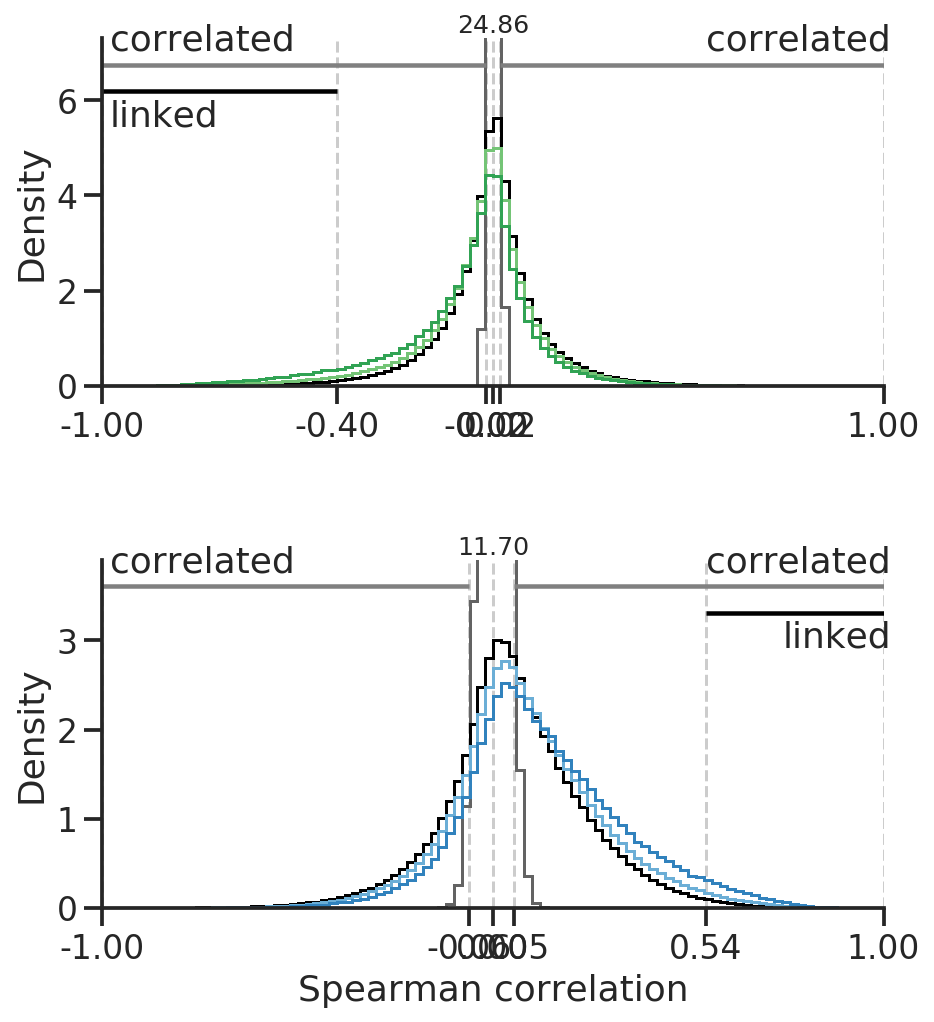

In [17]:
fname1 = iterator_mc[iterator_mc['r']==iterator_mc['r'].max()]['fname_mc'].iloc[0]
fname2 = iterator_atac[iterator_atac['r']==iterator_atac['r'].max()]['fname_atac'].iloc[0]

## organize data; get results
# get corrs
with open(fname1, 'rb') as fh:
    to_correlate, corrs, corrs_shuffled, corrs_shuffled_cells = pickle.load(fh)
res_corrs = enhancer_gene_to_eval[to_correlate].copy()
res_corrs['corr'] = corrs 
res_corrs['corr_shuff'] = corrs_shuffled
res_corrs['corr_shuff_cells'] = corrs_shuffled_cells

# get corrs
with open(fname2, 'rb') as fh:
    to_correlate, corrs, corrs_shuffled, corrs_shuffled_cells = pickle.load(fh)
res2_corrs = enhancer_gene_to_eval[to_correlate].copy()
res2_corrs['corr'] = corrs 
res2_corrs['corr_shuff'] = corrs_shuffled
res2_corrs['corr_shuff_cells'] = corrs_shuffled_cells

# corr_res
pval_type_shuffled, pval_type_shuffled_cells = 'left', 'both'
dist_th = 1e5
fdr_th = 0.2
res_stats = enhancer_gene_utils.get_significance_stats(
                            res_corrs[['gene', 'enh', 'dist']],
                            res_corrs['corr'],
                            res_corrs['corr_shuff'],
                            res_corrs['corr_shuff_cells'],
                            pval_type_shuffled, pval_type_shuffled_cells,
                            bins=bins,
                            distance_threshold=dist_th,
                            fdr_threshold=fdr_th,
                            positive_side=False,
                            return_pval=True,
                            return_cdf=False,
                        )

res2_stats = enhancer_gene_utils.get_significance_stats(
                            res2_corrs[['gene', 'enh', 'dist']],
                            res2_corrs['corr'],
                            res2_corrs['corr_shuff'],
                            res2_corrs['corr_shuff_cells'],
                            pval_type_shuffled, pval_type_shuffled_cells,
                            bins=bins,
                            distance_threshold=dist_th,
                            fdr_threshold=fdr_th,
                            positive_side=True,
                            return_pval=True,
                            return_cdf=False,
                        )
## plot
output = output_figures.format('hist_corr_both')
print(output)

# prep plot
(colors, corr_tracks, labels, vertical_lines,
 colors2, corr_tracks2, labels2, vertical_lines2,
 subsample_rates,) = prep_plot_dist_both(res_corrs, res2_corrs, 
                                         res_stats, res2_stats,
                                         colors_mc, colors_atac, colors_null, 
                                         ATAC_SIGN=ATAC_SIGN,
                                        )
# plot
plot_dist_both(
    colors, corr_tracks, labels, vertical_lines, 
    colors2, corr_tracks2, labels2, vertical_lines2, 
    subsample_rates,
    fancy=False,
    output=output,
    )

# apply to many

In [18]:
iterator_both

r  i   k                                           fname_mc  \
0     1.000000  0  30  /cndd2/fangming/projects/scf_enhancers/results...   
1     1.258925  0  30  /cndd2/fangming/projects/scf_enhancers/results...   
2     1.584893  0  30  /cndd2/fangming/projects/scf_enhancers/results...   
3     1.995262  0  30  /cndd2/fangming/projects/scf_enhancers/results...   
9     2.511886  0  30  /cndd2/fangming/projects/scf_enhancers/results...   
11    3.162278  0  30  /cndd2/fangming/projects/scf_enhancers/results...   
12    3.981072  0  30  /cndd2/fangming/projects/scf_enhancers/results...   
15    5.011872  0  30  /cndd2/fangming/projects/scf_enhancers/results...   
17    6.309573  0  30  /cndd2/fangming/projects/scf_enhancers/results...   
19    7.943282  0  30  /cndd2/fangming/projects/scf_enhancers/results...   
4    10.000000  0  30  /cndd2/fangming/projects/scf_enhancers/results...   
6    12.589254  0  30  /cndd2/fangming/projects/scf_enhancers/results...   
7    15.848932  0  30  /cndd2/fangming/projects/scf_enhancers/results...   
8    19.952623  0  30  /cndd2/fangming/projects/scf_enhancers/results...   
10   25.118864  0  30  /cndd2/fangming/projects/scf_enhancers/results...   
13   31.622777  0  30  /cndd2/fangming/projects/scf_enhancers/results...   
14   39.810717  0  30  /cndd2/fangming/projects/scf_enhancers/results...   
16   50.118723  0  30  /cndd2/fangming/projects/scf_enhancers/results...   
18   63.095734  0  30  /cndd2/fangming/projects/scf_enhancers/results...   
20   79.432823  0  30  /cndd2/fangming/projects/scf_enhancers/results...   
5   100.000000  0  30  /cndd2/fangming/projects/scf_enhancers/results...   

                                           fname_atac  num_linked_pairs_mc  \
0   /cndd2/fangming/projects/scf_enhancers/results...                 5137   
1   /cndd2/fangming/projects/scf_enhancers/results...                 6794   
2   /cndd2/fangming/projects/scf_enhancers/results...                 7447   
3   /cndd2/fangming/projects/scf_enhancers/results...                 9341   
9   /cndd2/fangming/projects/scf_enhancers/results...                 9429   
11  /cndd2/fangming/projects/scf_enhancers/results...                 8930   
12  /cndd2/fangming/projects/scf_enhancers/results...                10033   
15  /cndd2/fangming/projects/scf_enhancers/results...                10419   
17  /cndd2/fangming/projects/scf_enhancers/results...                10738   
19  /cndd2/fangming/projects/scf_enhancers/results...                11080   
4   /cndd2/fangming/projects/scf_enhancers/results...                10572   
6   /cndd2/fangming/projects/scf_enhancers/results...                10764   
7   /cndd2/fangming/projects/scf_enhancers/results...                10920   
8   /cndd2/fangming/projects/scf_enhancers/results...                11364   
10  /cndd2/fangming/projects/scf_enhancers/results...                11207   
13  /cndd2/fangming/projects/scf_enhancers/results...                11592   
14  /cndd2/fangming/projects/scf_enhancers/results...                12515   
16  /cndd2/fangming/projects/scf_enhancers/results...                11728   
18  /cndd2/fangming/projects/scf_enhancers/results...                12609   
20  /cndd2/fangming/projects/scf_enhancers/results...                12683   
5   /cndd2/fangming/projects/scf_enhancers/results...                12556   

    num_linked_genes_mc  num_linked_enhs_mc  \
0                  1735                4726   
1                  1948                6181   
2                  1990                6788   
3                  2356                8433   
9                  2204                8553   
11                 2147                8202   
12                 2265                9195   
15                 2331                9503   
17                 2319                9809   
19                 2424               10098   
4                  2313                9673   
6                  2350                9874   
7           

failed to detect r_threshold:
/cndd2/fangming/projects/scf_enhancers/results/figures/2020-12-11_metacell_corr_res_hist_corr_both_r1.00.pdf


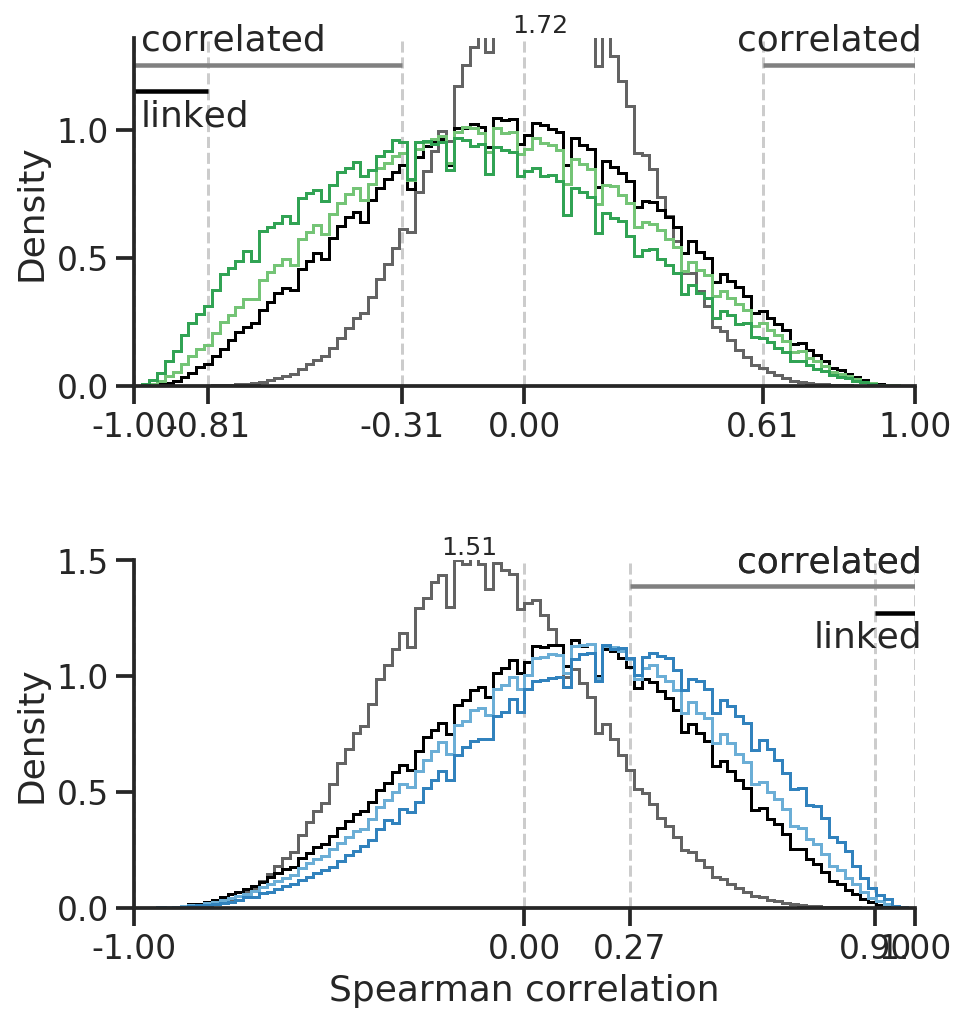

/cndd2/fangming/projects/scf_enhancers/results/figures/2020-12-11_metacell_corr_res_hist_corr_both_r1.26.pdf


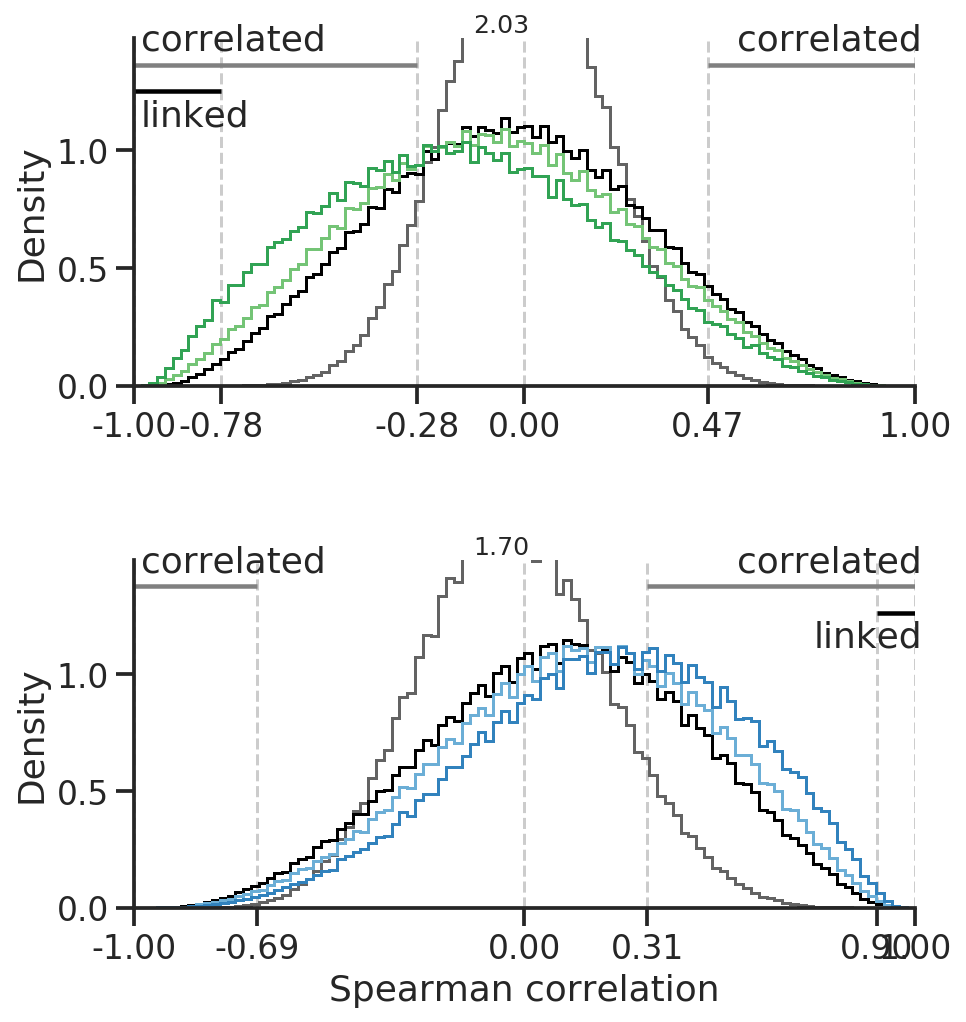

/cndd2/fangming/projects/scf_enhancers/results/figures/2020-12-11_metacell_corr_res_hist_corr_both_r1.58.pdf


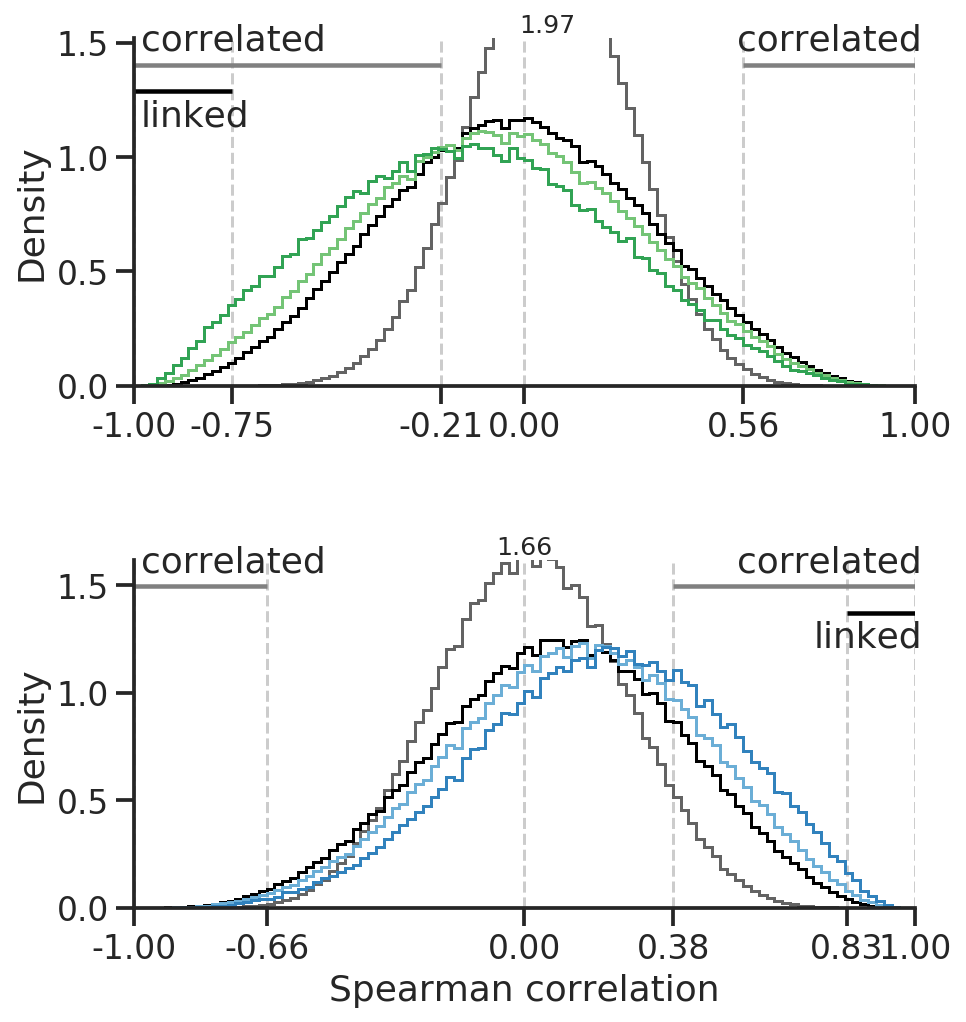

/cndd2/fangming/projects/scf_enhancers/results/figures/2020-12-11_metacell_corr_res_hist_corr_both_r2.00.pdf


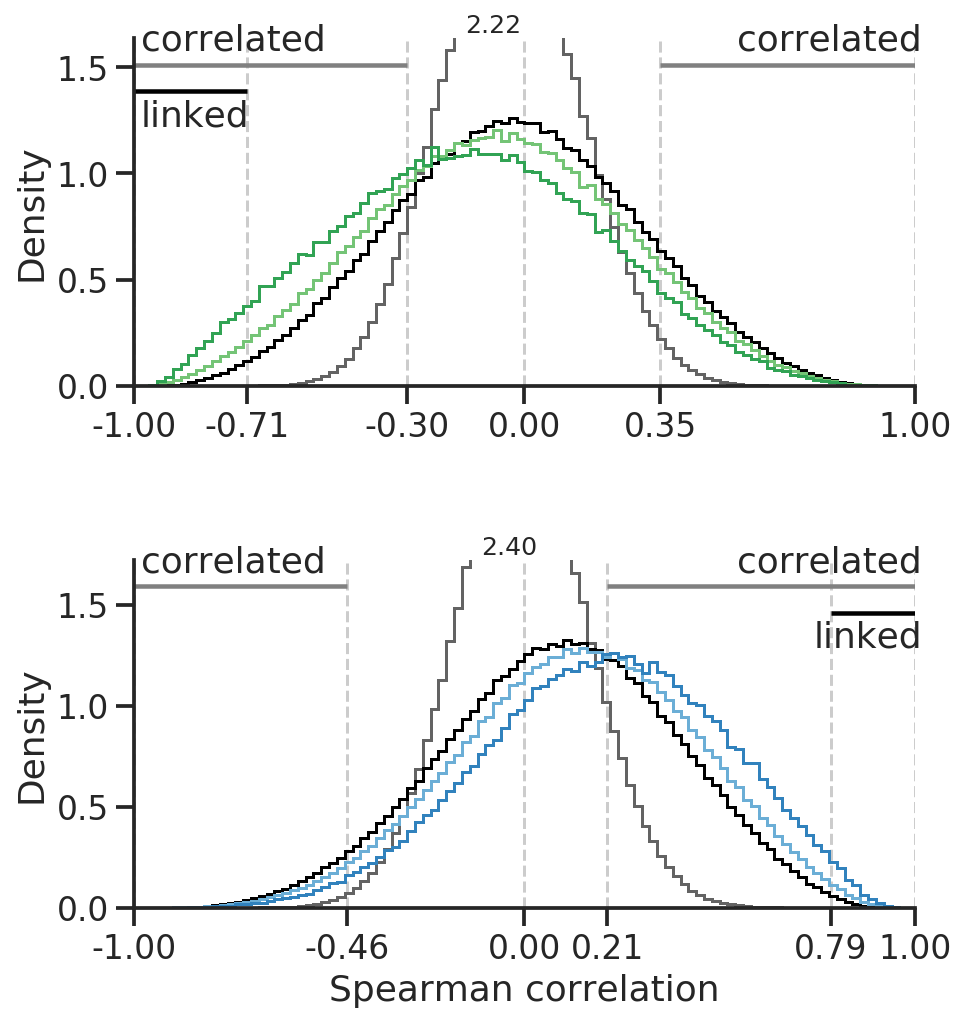

/cndd2/fangming/projects/scf_enhancers/results/figures/2020-12-11_metacell_corr_res_hist_corr_both_r2.51.pdf


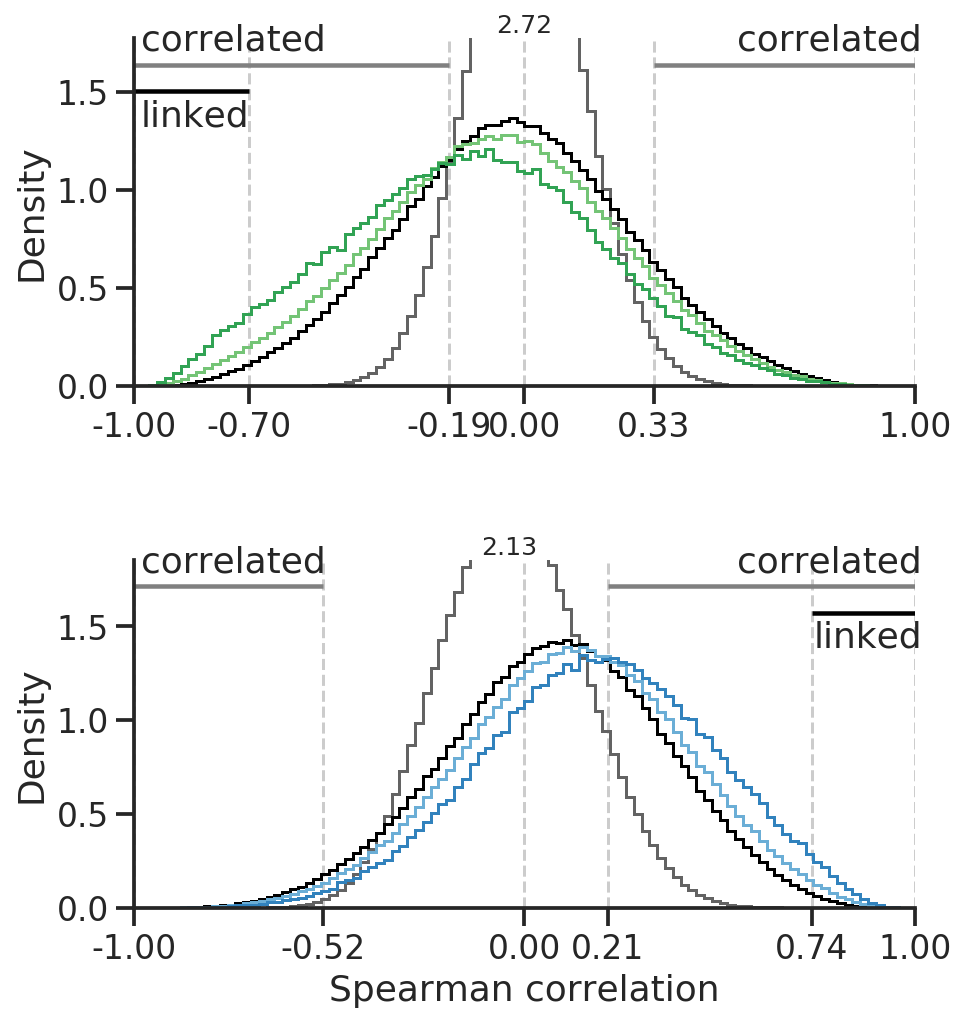

/cndd2/fangming/projects/scf_enhancers/results/figures/2020-12-11_metacell_corr_res_hist_corr_both_r3.16.pdf


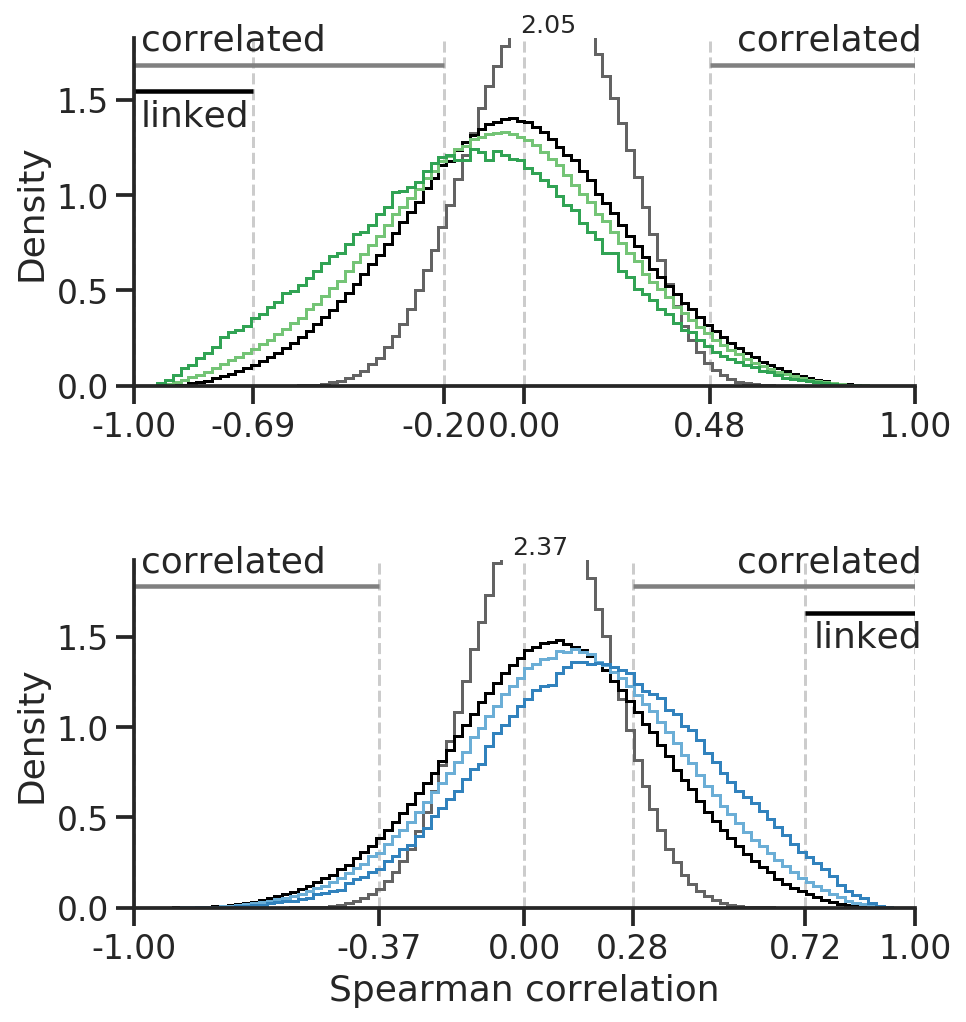

/cndd2/fangming/projects/scf_enhancers/results/figures/2020-12-11_metacell_corr_res_hist_corr_both_r3.98.pdf


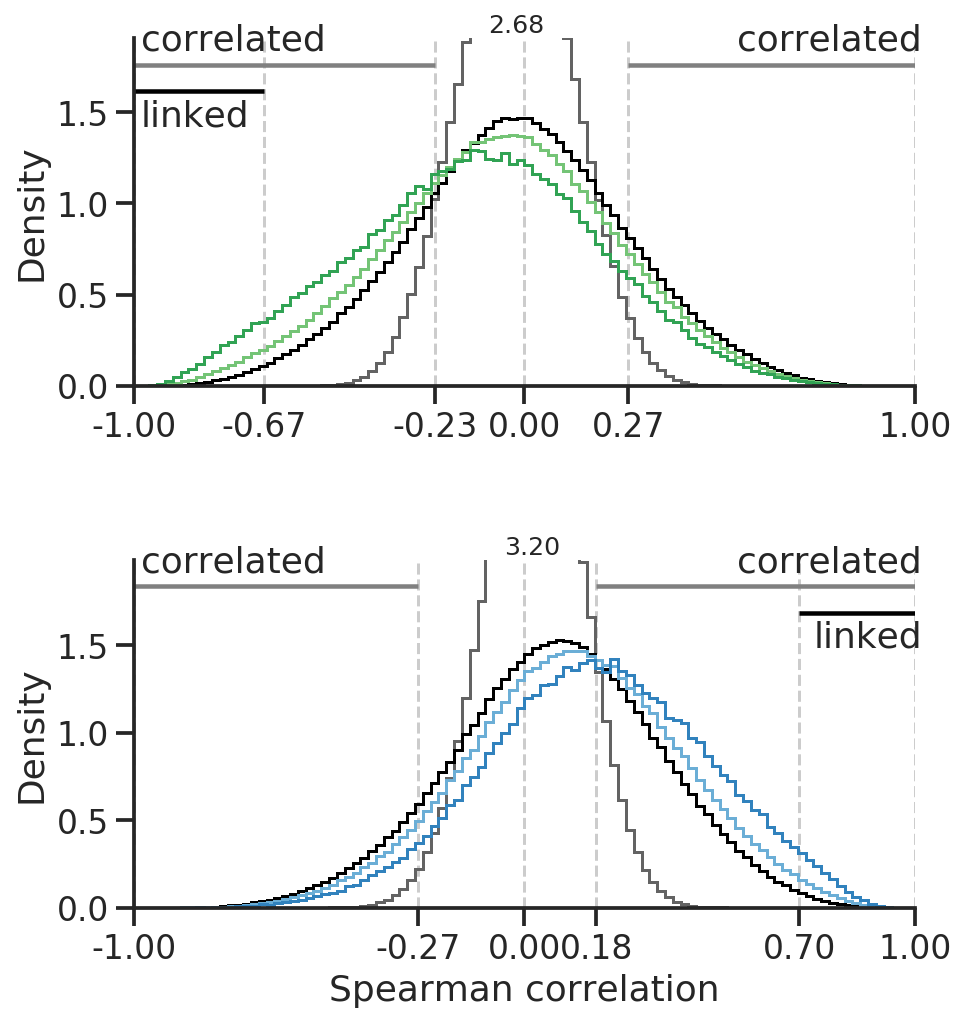

/cndd2/fangming/projects/scf_enhancers/results/figures/2020-12-11_metacell_corr_res_hist_corr_both_r5.01.pdf


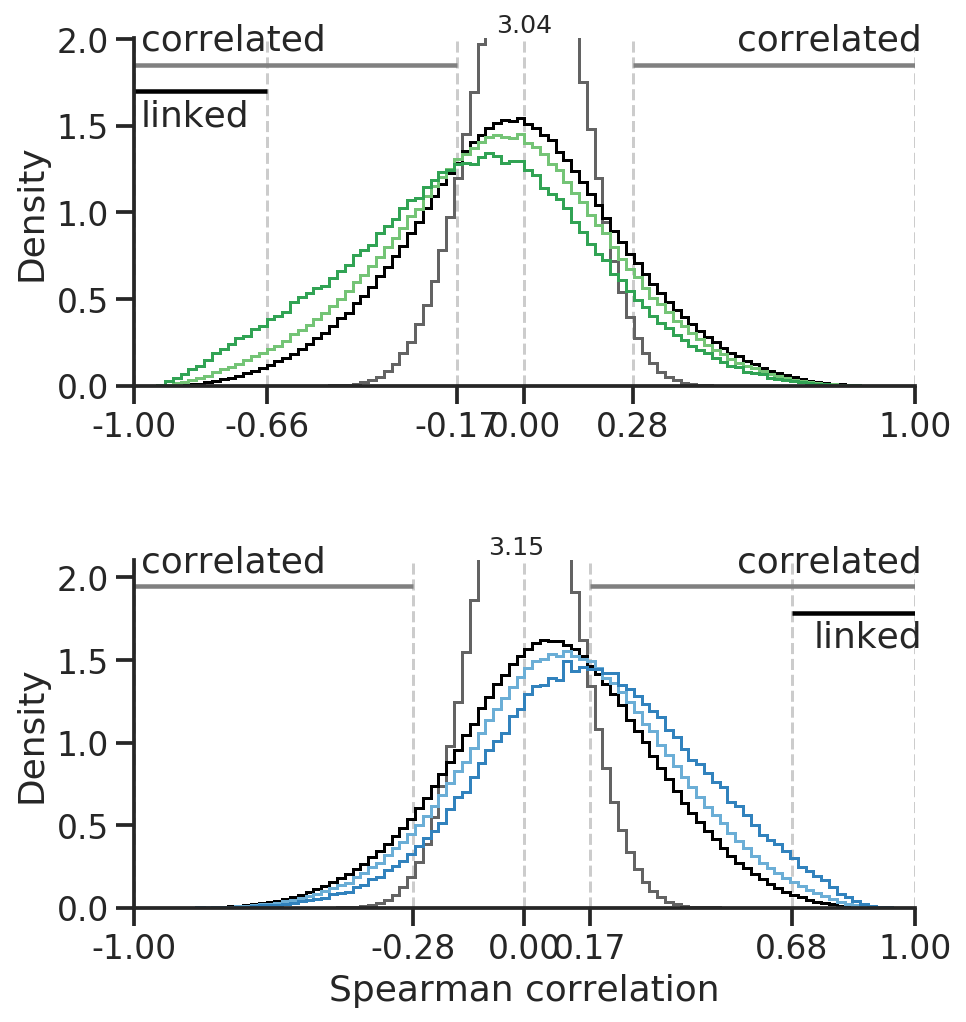

/cndd2/fangming/projects/scf_enhancers/results/figures/2020-12-11_metacell_corr_res_hist_corr_both_r6.31.pdf


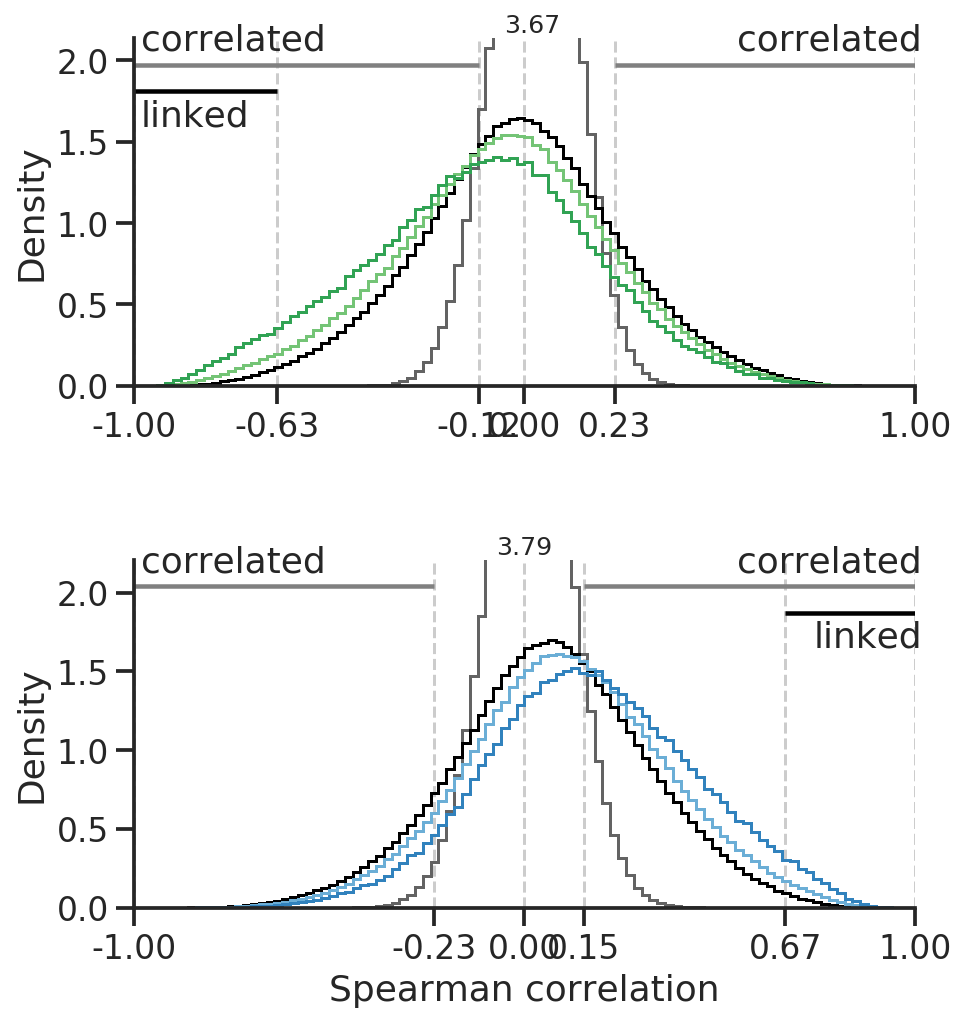

/cndd2/fangming/projects/scf_enhancers/results/figures/2020-12-11_metacell_corr_res_hist_corr_both_r7.94.pdf


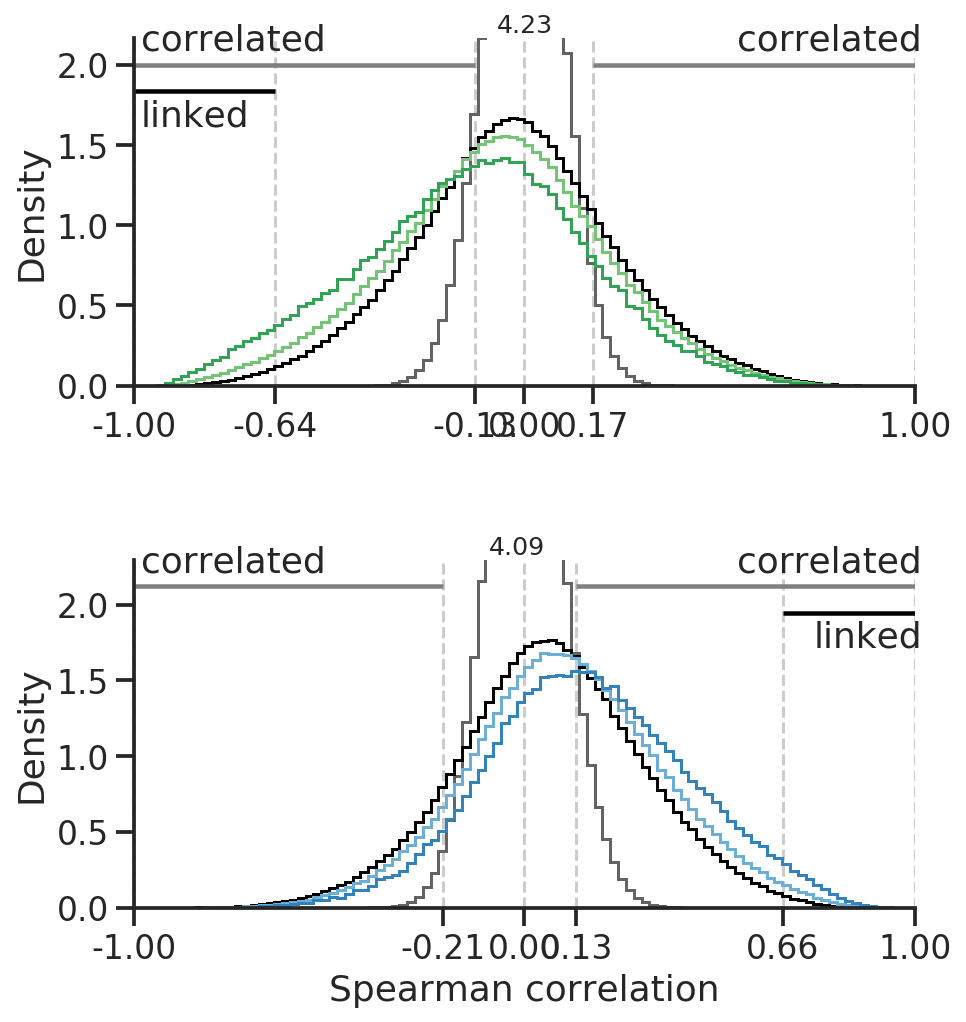

/cndd2/fangming/projects/scf_enhancers/results/figures/2020-12-11_metacell_corr_res_hist_corr_both_r10.00.pdf


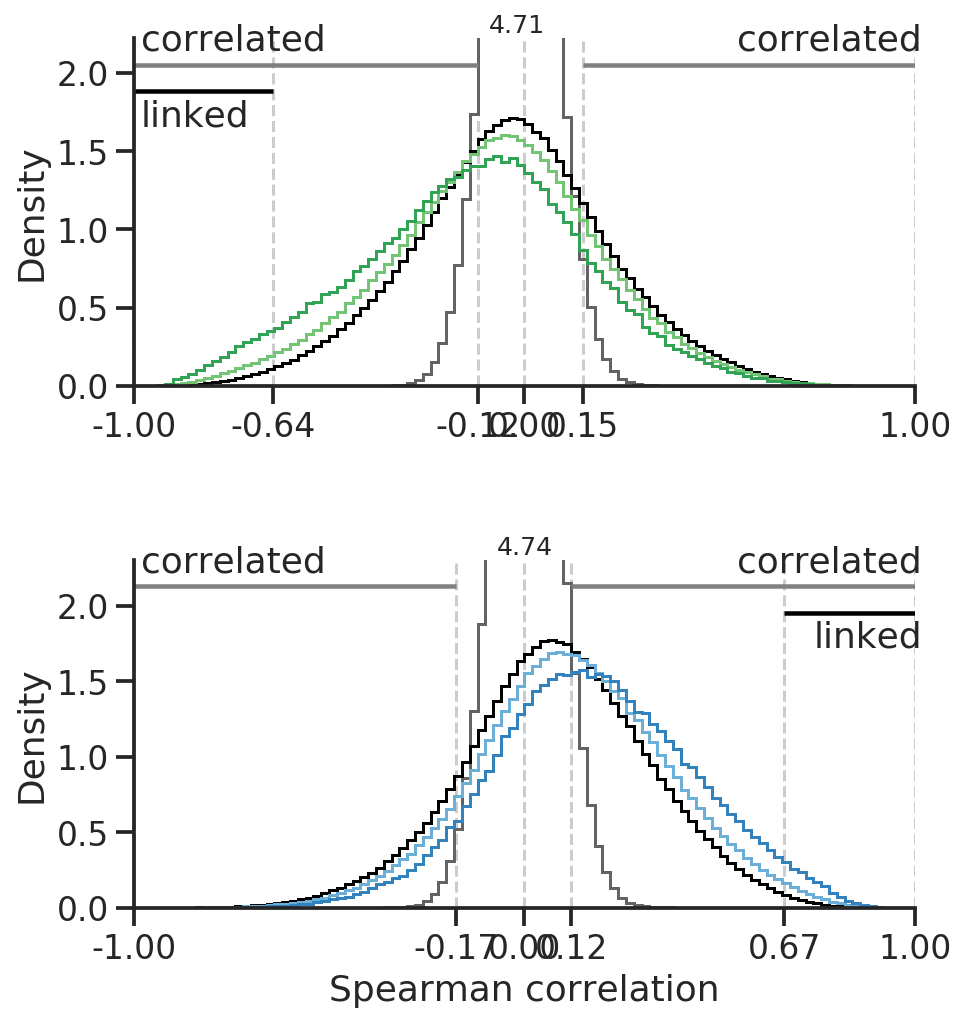

/cndd2/fangming/projects/scf_enhancers/results/figures/2020-12-11_metacell_corr_res_hist_corr_both_r12.59.pdf


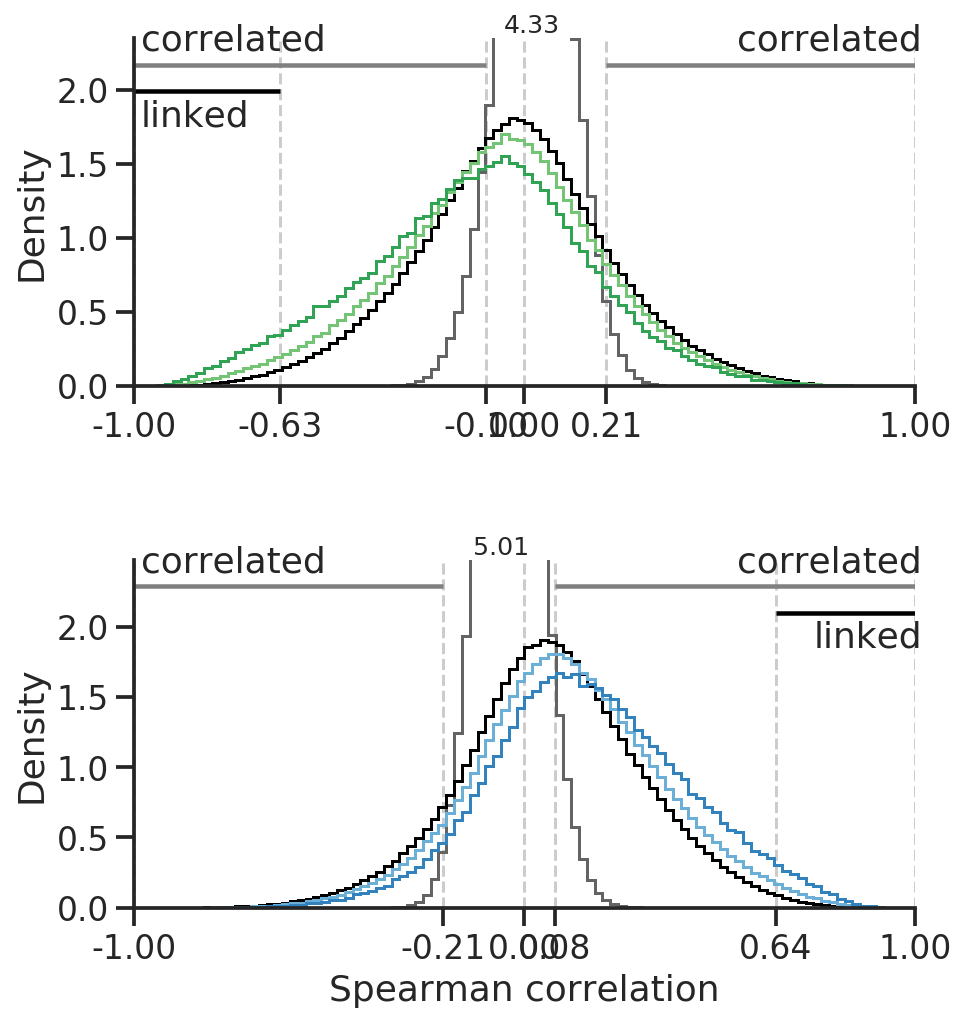

/cndd2/fangming/projects/scf_enhancers/results/figures/2020-12-11_metacell_corr_res_hist_corr_both_r15.85.pdf


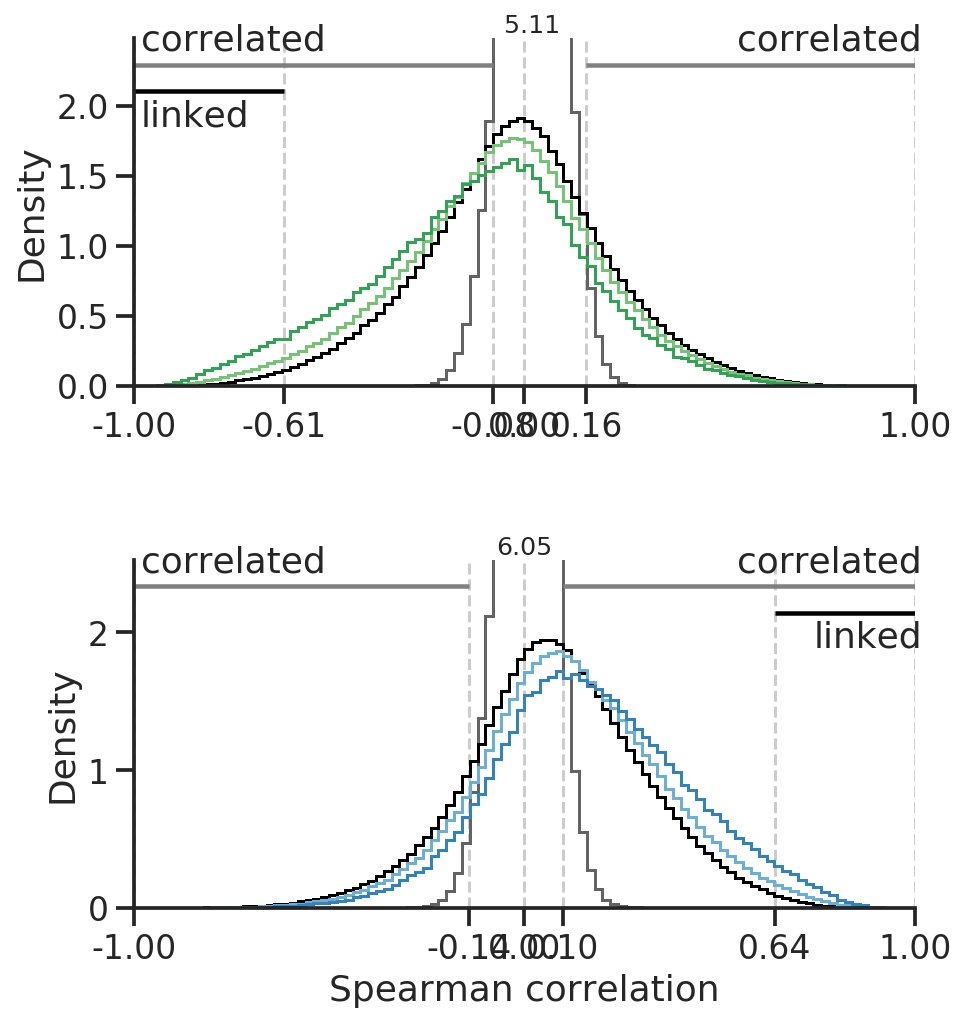

/cndd2/fangming/projects/scf_enhancers/results/figures/2020-12-11_metacell_corr_res_hist_corr_both_r19.95.pdf


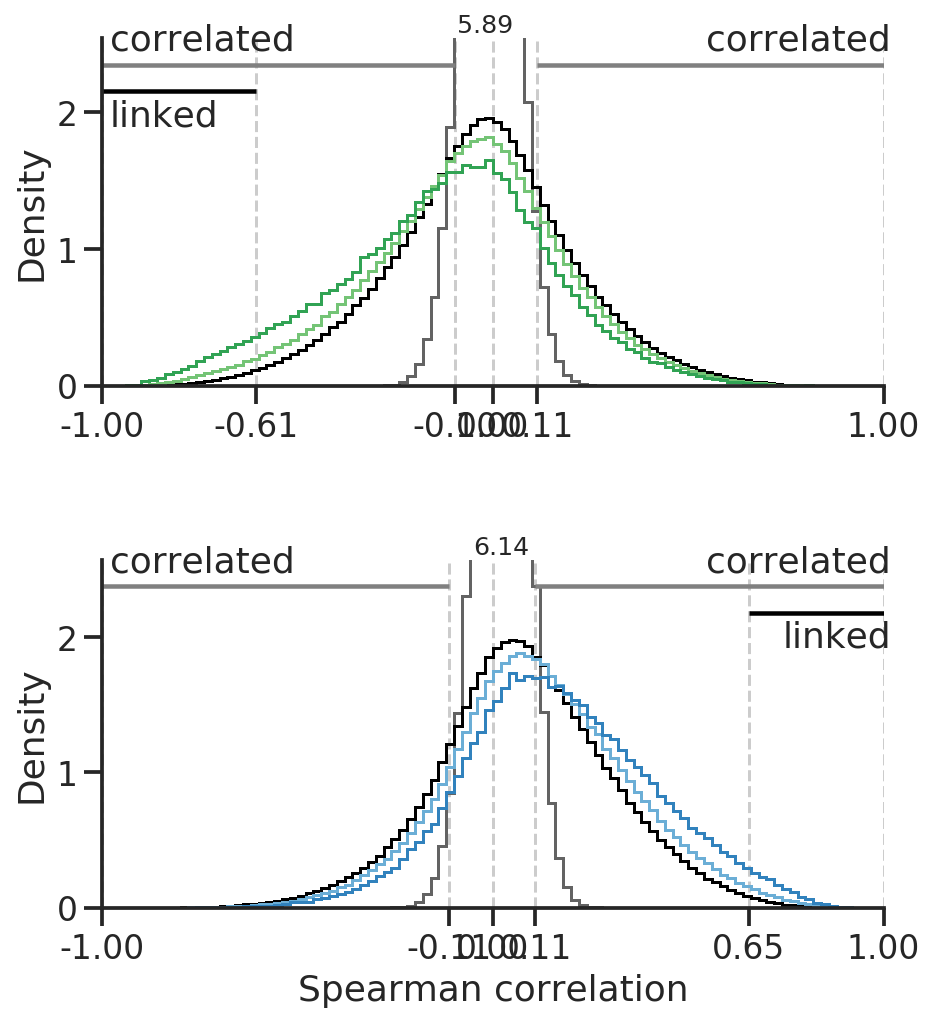

/cndd2/fangming/projects/scf_enhancers/results/figures/2020-12-11_metacell_corr_res_hist_corr_both_r25.12.pdf


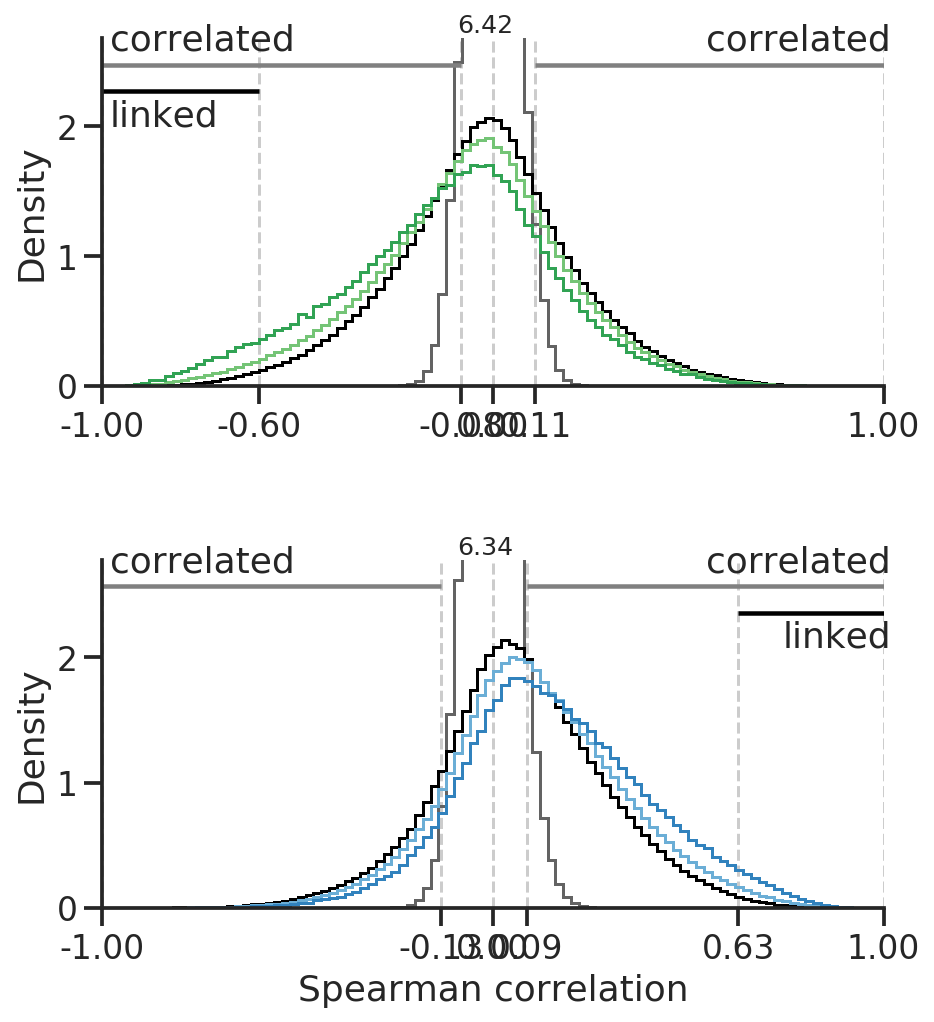

/cndd2/fangming/projects/scf_enhancers/results/figures/2020-12-11_metacell_corr_res_hist_corr_both_r31.62.pdf


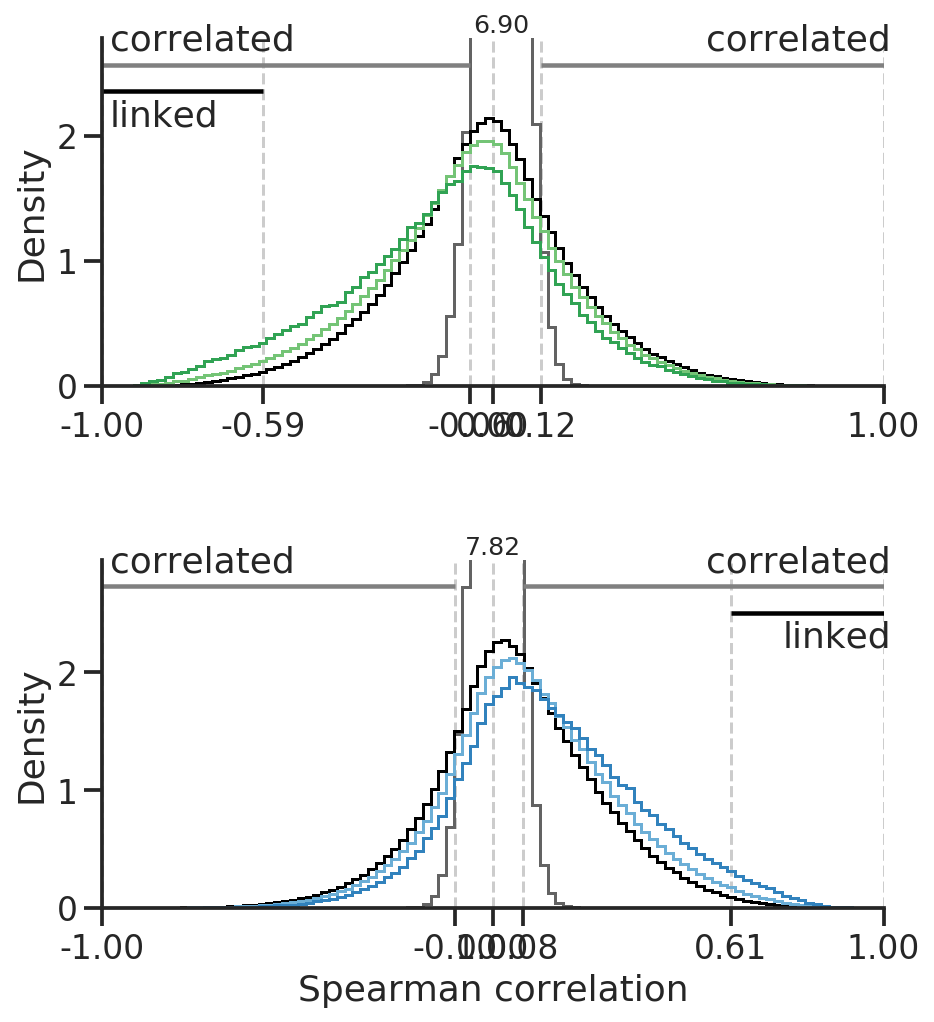

/cndd2/fangming/projects/scf_enhancers/results/figures/2020-12-11_metacell_corr_res_hist_corr_both_r39.81.pdf


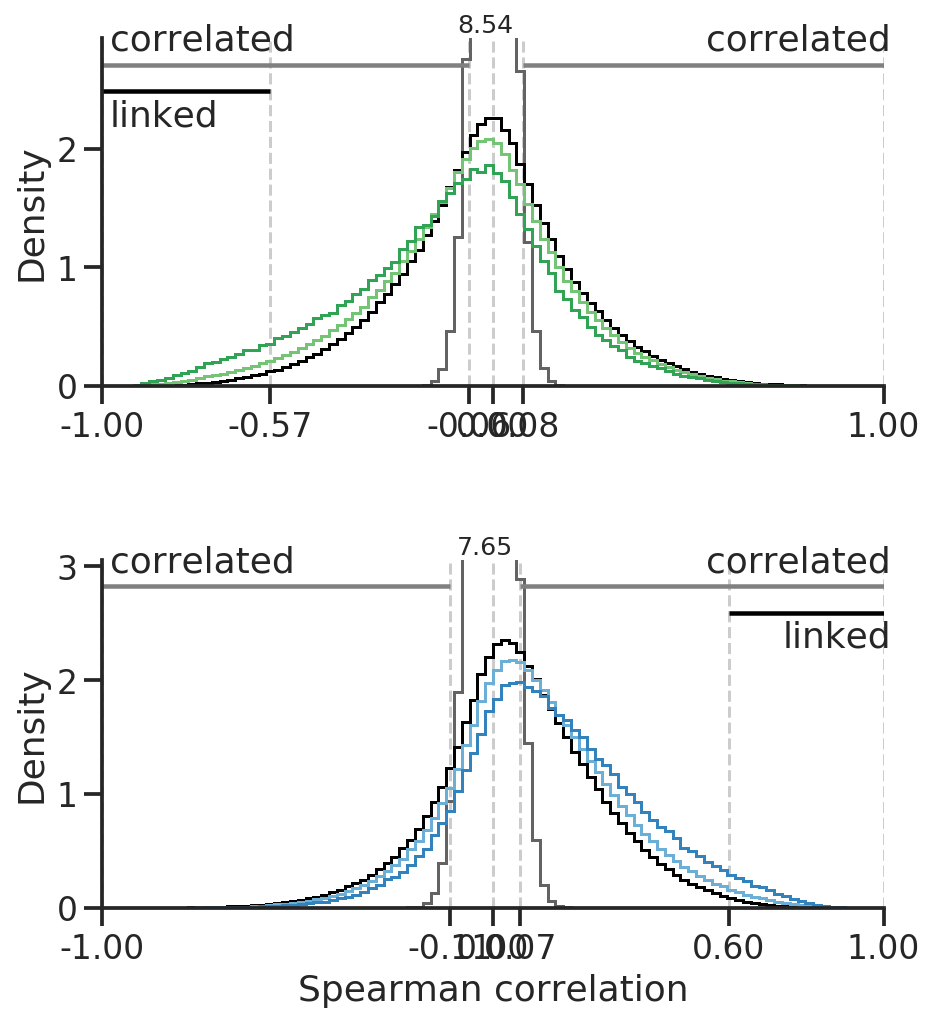

/cndd2/fangming/projects/scf_enhancers/results/figures/2020-12-11_metacell_corr_res_hist_corr_both_r50.12.pdf


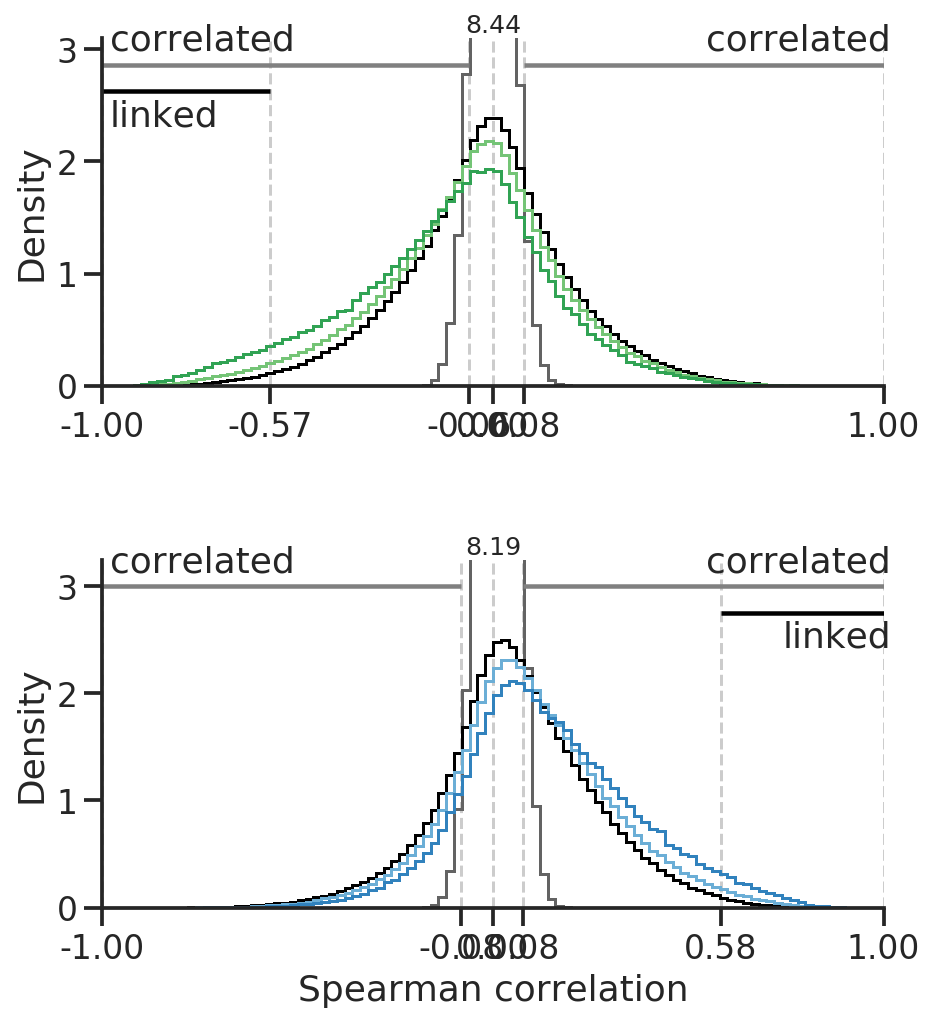

/cndd2/fangming/projects/scf_enhancers/results/figures/2020-12-11_metacell_corr_res_hist_corr_both_r63.10.pdf


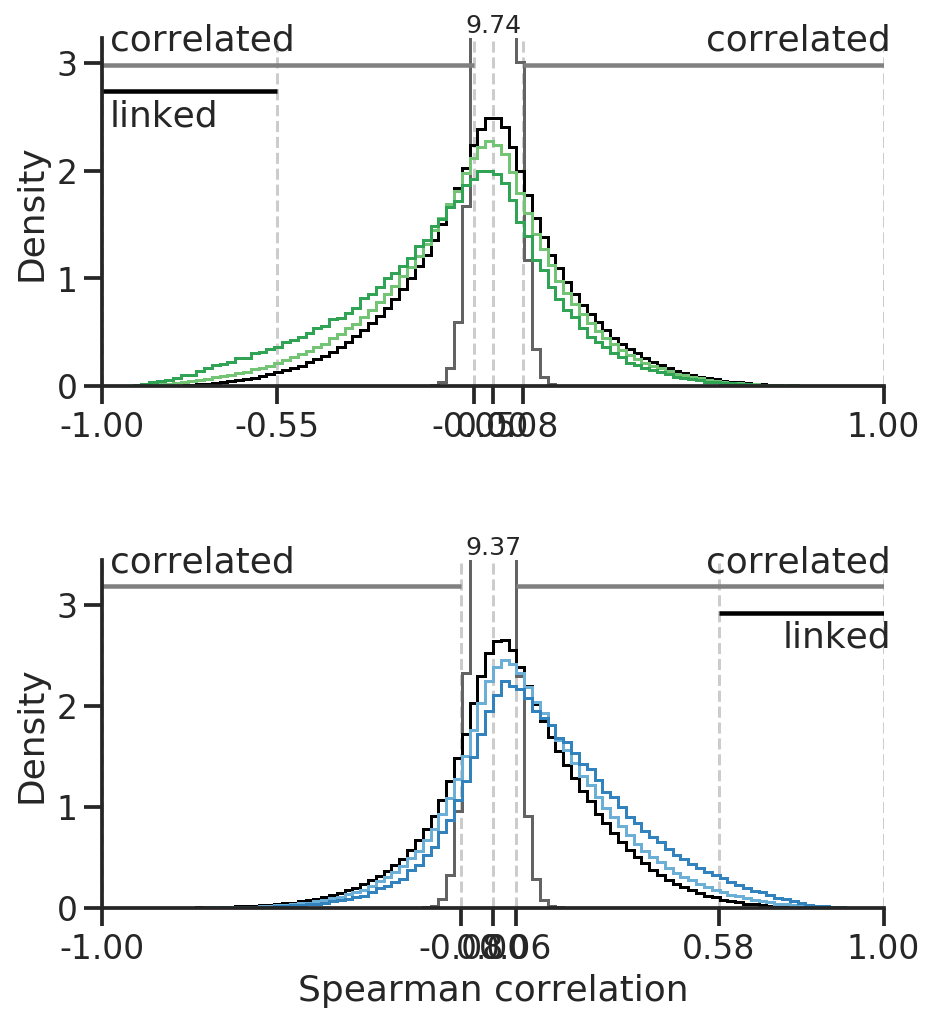

/cndd2/fangming/projects/scf_enhancers/results/figures/2020-12-11_metacell_corr_res_hist_corr_both_r79.43.pdf


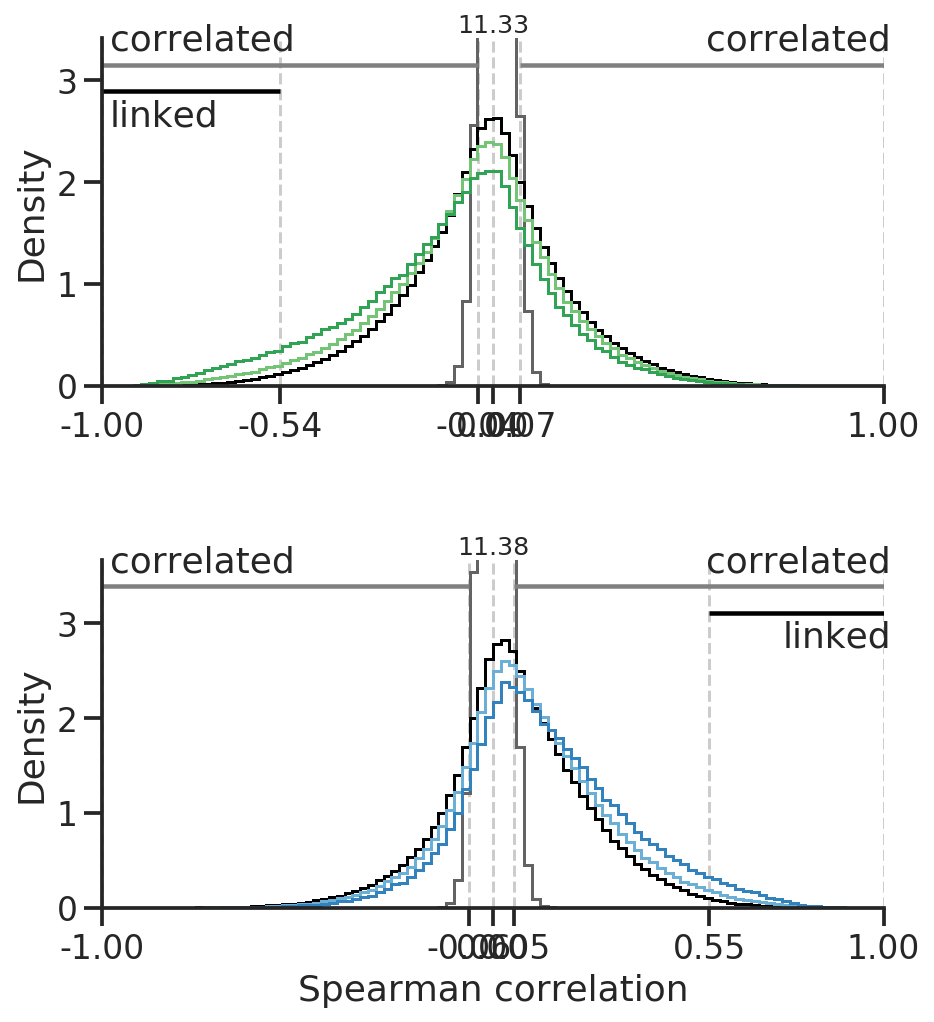

/cndd2/fangming/projects/scf_enhancers/results/figures/2020-12-11_metacell_corr_res_hist_corr_both_r100.00.pdf


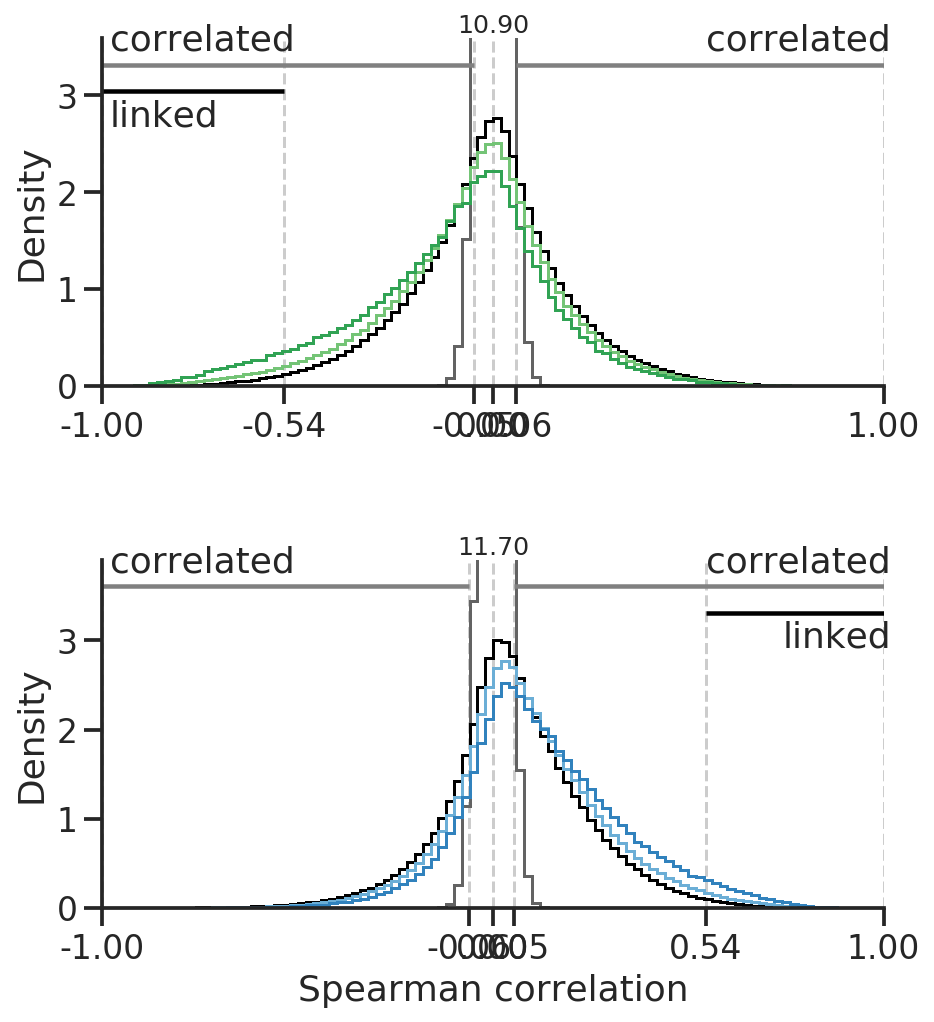

In [19]:
for idx, row in iterator_both.sort_values('r').iterrows(): 
    fname1, fname2 = row['fname_mc'], row['fname_atac']
    
    ## organize data; get results
    # get corrs
    with open(fname1, 'rb') as fh:
        to_correlate, corrs, corrs_shuffled, corrs_shuffled_cells = pickle.load(fh)
    res_corrs = enhancer_gene_to_eval[to_correlate].copy()
    res_corrs['corr'] = corrs 
    res_corrs['corr_shuff'] = corrs_shuffled
    res_corrs['corr_shuff_cells'] = corrs_shuffled_cells

    # get corrs
    with open(fname2, 'rb') as fh:
        to_correlate, corrs, corrs_shuffled, corrs_shuffled_cells = pickle.load(fh)
    res2_corrs = enhancer_gene_to_eval[to_correlate].copy()
    res2_corrs['corr'] = corrs 
    res2_corrs['corr_shuff'] = corrs_shuffled
    res2_corrs['corr_shuff_cells'] = corrs_shuffled_cells

    # corr_res
    pval_type_shuffled, pval_type_shuffled_cells = 'left', 'both'
    dist_th = 1e5
    fdr_th = 0.2
    res_stats = enhancer_gene_utils.get_significance_stats(
                                res_corrs[['gene', 'enh', 'dist']],
                                res_corrs['corr'],
                                res_corrs['corr_shuff'],
                                res_corrs['corr_shuff_cells'],
                                pval_type_shuffled, pval_type_shuffled_cells,
                                bins=bins,
                                distance_threshold=dist_th,
                                fdr_threshold=fdr_th,
                                positive_side=False,
                                return_pval=True,
                                return_cdf=False,
                            )

    res2_stats = enhancer_gene_utils.get_significance_stats(
                                res2_corrs[['gene', 'enh', 'dist']],
                                res2_corrs['corr'],
                                res2_corrs['corr_shuff'],
                                res2_corrs['corr_shuff_cells'],
                                pval_type_shuffled, pval_type_shuffled_cells,
                                bins=bins,
                                distance_threshold=dist_th,
                                fdr_threshold=fdr_th,
                                positive_side=True,
                                return_pval=True,
                                return_cdf=False,
                            )
    ## plot
    output = output_figures.format('hist_corr_both_r{:.2f}'.format(row['r']))
    print(output)

    # prep plot
    (colors, corr_tracks, labels, vertical_lines,
     colors2, corr_tracks2, labels2, vertical_lines2,
     subsample_rates,) = prep_plot_dist_both(res_corrs, res2_corrs, 
                                             res_stats, res2_stats,
                                             colors_mc, colors_atac, colors_null, 
                                             ATAC_SIGN=ATAC_SIGN,
                                            )
    # plot
    plot_dist_both(
        colors, corr_tracks, labels, vertical_lines, 
        colors2, corr_tracks2, labels2, vertical_lines2, 
        subsample_rates,
        fancy=False,
        output=output,
        )

# resimplify and summarize 

In [20]:
res_all = []

for idx, row in iterator_both.sort_values('r').iterrows(): 
    fname1, fname2 = row['fname_mc'], row['fname_atac']
    
    ## organize data; get results
    # get corrs
    with open(fname1, 'rb') as fh:
        to_correlate, corrs, corrs_shuffled, corrs_shuffled_cells = pickle.load(fh)
    res_corrs = enhancer_gene_to_eval[to_correlate].copy()
    res_corrs['corr'] = corrs 
    res_corrs['corr_shuff'] = corrs_shuffled
    res_corrs['corr_shuff_cells'] = corrs_shuffled_cells

    # get corrs
    with open(fname2, 'rb') as fh:
        to_correlate, corrs, corrs_shuffled, corrs_shuffled_cells = pickle.load(fh)
    res2_corrs = enhancer_gene_to_eval[to_correlate].copy()
    res2_corrs['corr'] = corrs 
    res2_corrs['corr_shuff'] = corrs_shuffled
    res2_corrs['corr_shuff_cells'] = corrs_shuffled_cells

    # corr_res
    pval_type_shuffled, pval_type_shuffled_cells = 'left', 'both'
    dist_th = 1e5
    fdr_th = 0.2
    res_stats = enhancer_gene_utils.get_significance_stats(
                                res_corrs[['gene', 'enh', 'dist']],
                                res_corrs['corr'],
                                res_corrs['corr_shuff'],
                                res_corrs['corr_shuff_cells'],
                                pval_type_shuffled, pval_type_shuffled_cells,
                                bins=bins,
                                distance_threshold=dist_th,
                                fdr_threshold=fdr_th,
                                positive_side=False,
                                return_pval=True,
                                return_cdf=False,
                            )

    res2_stats = enhancer_gene_utils.get_significance_stats(
                                res2_corrs[['gene', 'enh', 'dist']],
                                res2_corrs['corr'],
                                res2_corrs['corr_shuff'],
                                res2_corrs['corr_shuff_cells'],
                                pval_type_shuffled, pval_type_shuffled_cells,
                                bins=bins,
                                distance_threshold=dist_th,
                                fdr_threshold=fdr_th,
                                positive_side=True,
                                return_pval=True,
                                return_cdf=False,
                            )
#     ## plot
#     output = output_figures.format('hist_corr_both_r{:.2f}'.format(row['r']))
#     print(output)

    # prep plot
    (colors, corr_tracks, labels, vertical_lines,
     colors2, corr_tracks2, labels2, vertical_lines2,
     subsample_rates,) = prep_plot_dist_both(res_corrs, res2_corrs, 
                                             res_stats, res2_stats,
                                             colors_mc, colors_atac, colors_null, 
                                             ATAC_SIGN=ATAC_SIGN,
                                            )
    
    res_all.append([row['r'], colors, corr_tracks, labels, vertical_lines,
                   colors2, corr_tracks2, labels2, vertical_lines2,
                   subsample_rates,])

#     # plot
#     plot_dist_both(
#         colors, corr_tracks, labels, vertical_lines, 
#         colors2, corr_tracks2, labels2, vertical_lines2, 
#         subsample_rates,
#         fancy=False,
#         output=output,
#         )

res_all = pd.DataFrame(res_all, columns=[
    'r', 'colors', 'corr_tracks', 'labels', 'vertical_lines',
    'colors2', 'corr_tracks2', 'labels2', 'vertical_lines2',
    'subsample_rates',])
res_all = pd.merge(res_clsts, res_all, on='r')
print(res_all.shape)
res_all.head()

failed to detect r_threshold:
(21, 13)


k  i         r  num_clst  \
0  30  0  1.000000        16   
1  30  0  1.258925        18   
2  30  0  1.584893        22   
3  30  0  1.995262        28   
4  30  0  2.511886        34   

                                              colors  \
0  [(0.38823529411764707, 0.38823529411764707, 0....   
1  [(0.38823529411764707, 0.38823529411764707, 0....   
2  [(0.38823529411764707, 0.38823529411764707, 0....   
3  [(0.38823529411764707, 0.38823529411764707, 0....   
4  [(0.38823529411764707, 0.38823529411764707, 0....   

                                         corr_tracks  \
0  [[0.1382352941176471, 0.10294117647058823, 0.0...   
1  [[-0.03376623376623377, 0.01558441558441558, -...   
2  [[0.3539130434782609, 0.033043478260869584, 0....   
3  [[-0.35369458128078823, 0.003940886699507383, ...   
4  [[-0.016731016731016728, -0.10115830115830117,...   

                                              labels  \
0  [shuffled cell types mCG-RNA, shuffled regions...   
1  [shuffled cell types mCG-RNA, shuffled regions...   
2  [shuffled cell types mCG-RNA, shuffled regions...   
3  [shuffled cell types mCG-RNA, shuffled regions...   
4  [shuffled cell types mCG-RNA, shuffled regions...   

                                      vertical_lines  \
0  [-0.8098868891318075, -0.3121033188489742, 0.6...   
1  [-0.7756232663217955, -0.27594666798378, 0.469...   
2  [-0.7475299352972663, -0.21401164289137964, 0....   
3  [-0.7108803610274742, -0.29939560941181037, 0....   
4  [-0.7046611772973725, -0.1938910419001954, 0.3...   

                                             colors2  \
0  [(0.38823529411764707, 0.38823529411764707, 0....   
1  [(0.38823529411764707, 0.38823529411764707, 0....   
2  [(0.38823529411764707, 0.38823529411764707, 0....   
3  [(0.38823529411764707, 0.38823529411764707, 0....   
4  [(0.38823529411764707, 0.38823529411764707, 0....   

                                        corr_tracks2  \
0  [[-0.44705882352941173, 0.2147058823529412, 0....   
1  [[0.23632610939112483, 0.16615067079463364, -0...   
2  [[-0.14963297571993228, 0.12140033879164314, -...   
3  [[-0.035577449370552815, -0.07170224411603728,...   
4  [[-0.15905271199388848, -0.13063407181054243, ...   

                                             labels2  \
0  [shuffled cell types ATAC-RNA, shuffled region...   
1  [shuffled cell types ATAC-RNA, shuffled region...   
2  [shuffled cell types ATAC-RNA, shuffled region...   
3  [shuffled cell types ATAC-RNA, shuffled region...   
4  [shuffled cell types ATAC-RNA, shuffled region...   

                                     vertical_lines2 subsample_rates  
0     [0.8983041173397398, 0.27056376644138597, nan]    [1, 1, 1, 1]  
1  [0.9024490450000239, 0.31455026314841017, -0.6...    [1, 1, 1, 1]  
2  [0.8254252420656429, 0.38165975034414384, -0.6...    [1, 1, 1, 1]  
3  [0.7850118523965579, 0.2122503787949774, -0.45...    [1, 1, 1, 1]  
4  [0.7360671581891676, 0.2140080818142557, -0.51...    [1, 1, 1, 1]

In [21]:
# plot distribution
def plot_dist_ax(
    ax,
    _colors, _corr_tracks, _labels, _vertical_lines, subsample_rates,
    ):
    """
    """
    fontsize = ax.xaxis.label.get_fontsize()

    # each line (color) is present in all columns; loop over lines
    histy_max = 0
    for j, (_x, label, color, subsample_rate) in enumerate(zip(
            _corr_tracks, _labels, _colors, subsample_rates)):
        # go over columns
        label_comp = '{} ({}, frac={})'.format(label, len(_x), subsample_rate)

        g = ax.hist(_x, bins=bins, 
                    histtype='step', 
                    label=label,
                    color=color, density=True)
        histy, histx, _ = g
        if j == 0:
            histy0_max = np.max(histy)
            histx0_max = bins[np.argmax(histy)]
        if j > 0:
            histy_max = max(histy_max, np.max(histy)) 

    ax.set_ylim([0, 1.3*histy_max])
    if histy0_max > 1.3*histy_max:
        # text
        text_config = {
            'xy': (histx0_max, 1.3*histy_max), 
            'ha': 'center', 'va': 'bottom', 
            'xytext': (0, 0),
            'textcoords': 'offset points',
            'fontsize': 0.7*fontsize,
        }
        ax.annotate("{:.2f}".format(histy0_max), **text_config)

    # labels
    ax.set_xlabel('Spearman correlation')
    ax.set_ylabel('Density')
    ax.set_xlim([-1, 1])
    sns.despine(ax=ax)

    # line ticks
    ax.grid(which='major', axis='x', linestyle='--')
    ax.xaxis.set_major_formatter(mtick.StrMethodFormatter('{x:.2f}'))
    ax.set_xticks(np.sort(np.hstack([[-1, 0, 1], _vertical_lines])))

    # horizontal lines
    lineys = [1.1*histy_max, 1.2*histy_max, 1.2*histy_max]
    linecolors = ['k', 'gray', 'gray']
    texts = ['linked', 'correlated', 'correlated']
    vas = ['top', 'bottom', 'bottom']
    offsets = [(0.2*fontsize, -0.2*fontsize), 
               (0.2*fontsize, +0.2*fontsize), 
               (0.2*fontsize, +0.2*fontsize), 
              ]
    for xcoord, linecolor, liney, text, va, offset in zip(
        _vertical_lines, linecolors, lineys, texts, vas, offsets):
        if xcoord < 0:
            _x = -1
            xmin, xmax = -1, xcoord
            ha = 'left'
        else:
            _x = 1
            xmin, xmax = xcoord, 1 
            ha = 'right'
        # line
        ax.hlines(liney, xmin=xmin, xmax=xmax, color=linecolor, linestyle='-')
        # text
        text_config = {
            'xy': (_x, liney), 
            'ha': ha, 'va': va, 
            'xytext': offset,
            'textcoords': 'offset points',
            'fontsize': fontsize,
        }
        ax.annotate(text, **text_config)
    
    return 

/cndd2/fangming/projects/scf_enhancers/results/figures/2020-12-11_metacell_corr_res_hist_corr_both_grand.pdf


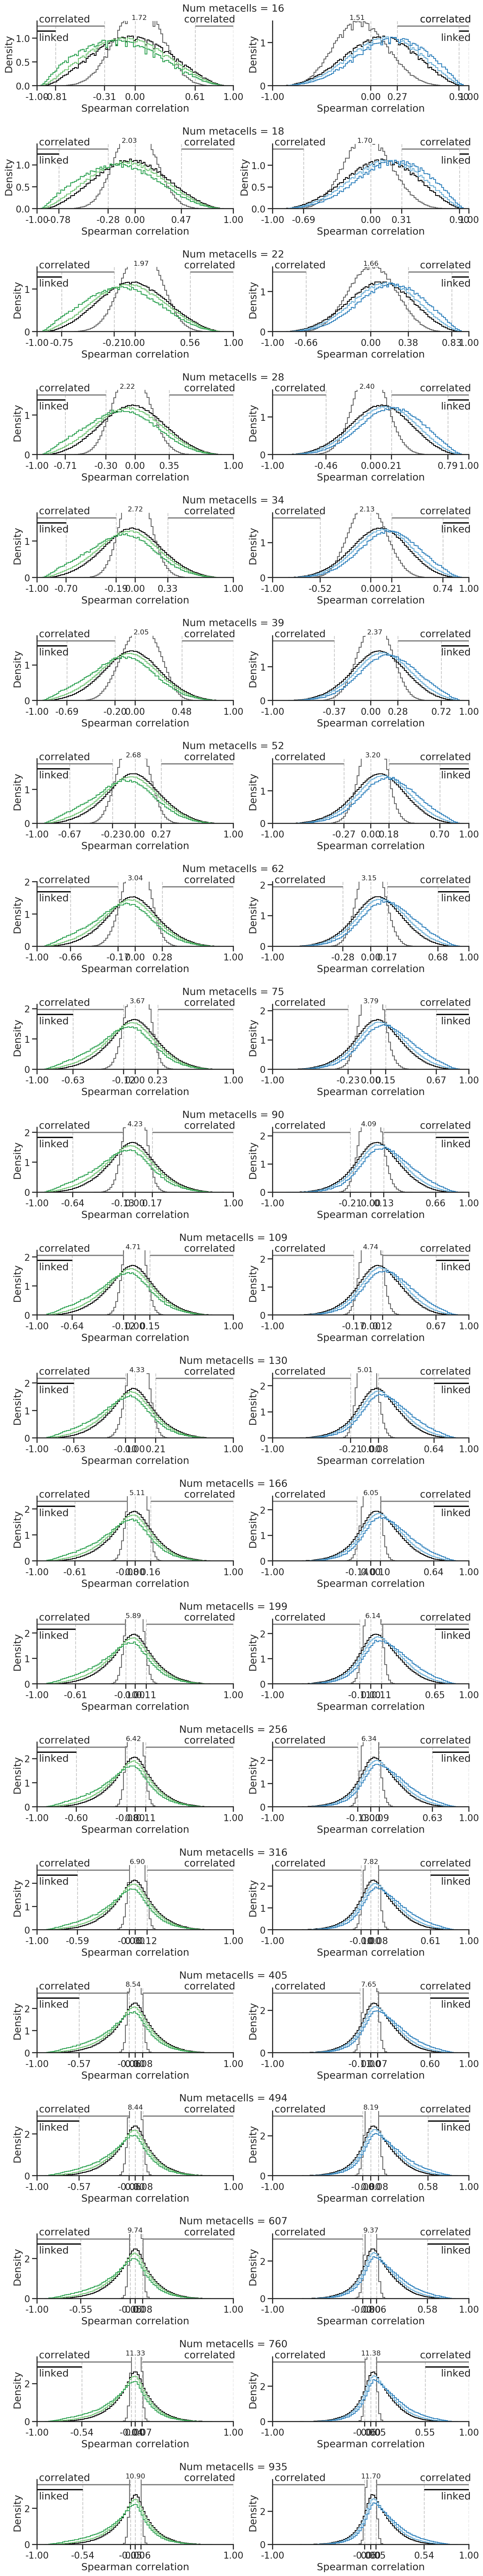

In [22]:
output = output_figures.format('hist_corr_both_grand')
print(output)

with sns.axes_style('ticks', {'axes.grid': False}):
    n = len(res_all)
    fig, axss = plt.subplots(n, 2, figsize=(7*2,4*n))
    for i, (idx, row) in enumerate(res_all.iterrows()):
        axs = axss[i]
        plot_dist_ax(axs[0], row['colors'], row['corr_tracks'], row['labels'], 
                     row['vertical_lines'], row['subsample_rates'],)
        
        plot_dist_ax(axs[1], row['colors2'], row['corr_tracks2'], row['labels2'], 
                     row['vertical_lines2'], row['subsample_rates'],)
        axs[0].set_title('Num metacells = {}'.format(row['num_clst']), ha='center', loc='right', y=1.1)
    # adjust
    fig.subplots_adjust(hspace=0.9)
    # savefig
    if output:
        fig.savefig(output, bbox_inches='tight')
    plt.show()

In [23]:
# summary
# gray distribution - peak width
# ...

res_summary = []
for i, (idx, row) in enumerate(res_all.iterrows()):
    for track_name, track in zip(row['labels'], row['corr_tracks']):
        lo = np.nanpercentile(track, 2.5)
        hi = np.nanpercentile(track, 97.5)
        res_summary.append({
            'num_clst': row['num_clst'],
            'track_name': track_name.replace(' mCG-RNA', ''),
            'mod': 'mc',
            'lo': lo,
            'hi': hi,
            'interval': hi-lo,
        })
    for track_name, track in zip(row['labels2'], row['corr_tracks2']):
        lo = np.nanpercentile(track, 2.5)
        hi = np.nanpercentile(track, 97.5)
        res_summary.append({
            'num_clst': row['num_clst'],
            'track_name': track_name.replace(' ATAC-RNA', ''),
            'mod': 'atac',
            'lo': lo,
            'hi': hi,
            'interval': hi-lo,
        })

res_summary = pd.DataFrame(res_summary)
print(res_summary.shape)
res_summary.head()

(168, 6)


num_clst           track_name   mod        lo        hi  interval
0        16  shuffled cell types    mc -0.429412  0.476471  0.905882
1        16     shuffled regions    mc -0.691176  0.652941  1.344118
2        16               <500kb    mc -0.747059  0.626471  1.373529
3        16               <100kb    mc -0.805882  0.591176  1.397059
4        16  shuffled cell types  atac -0.576471  0.428256  1.004727

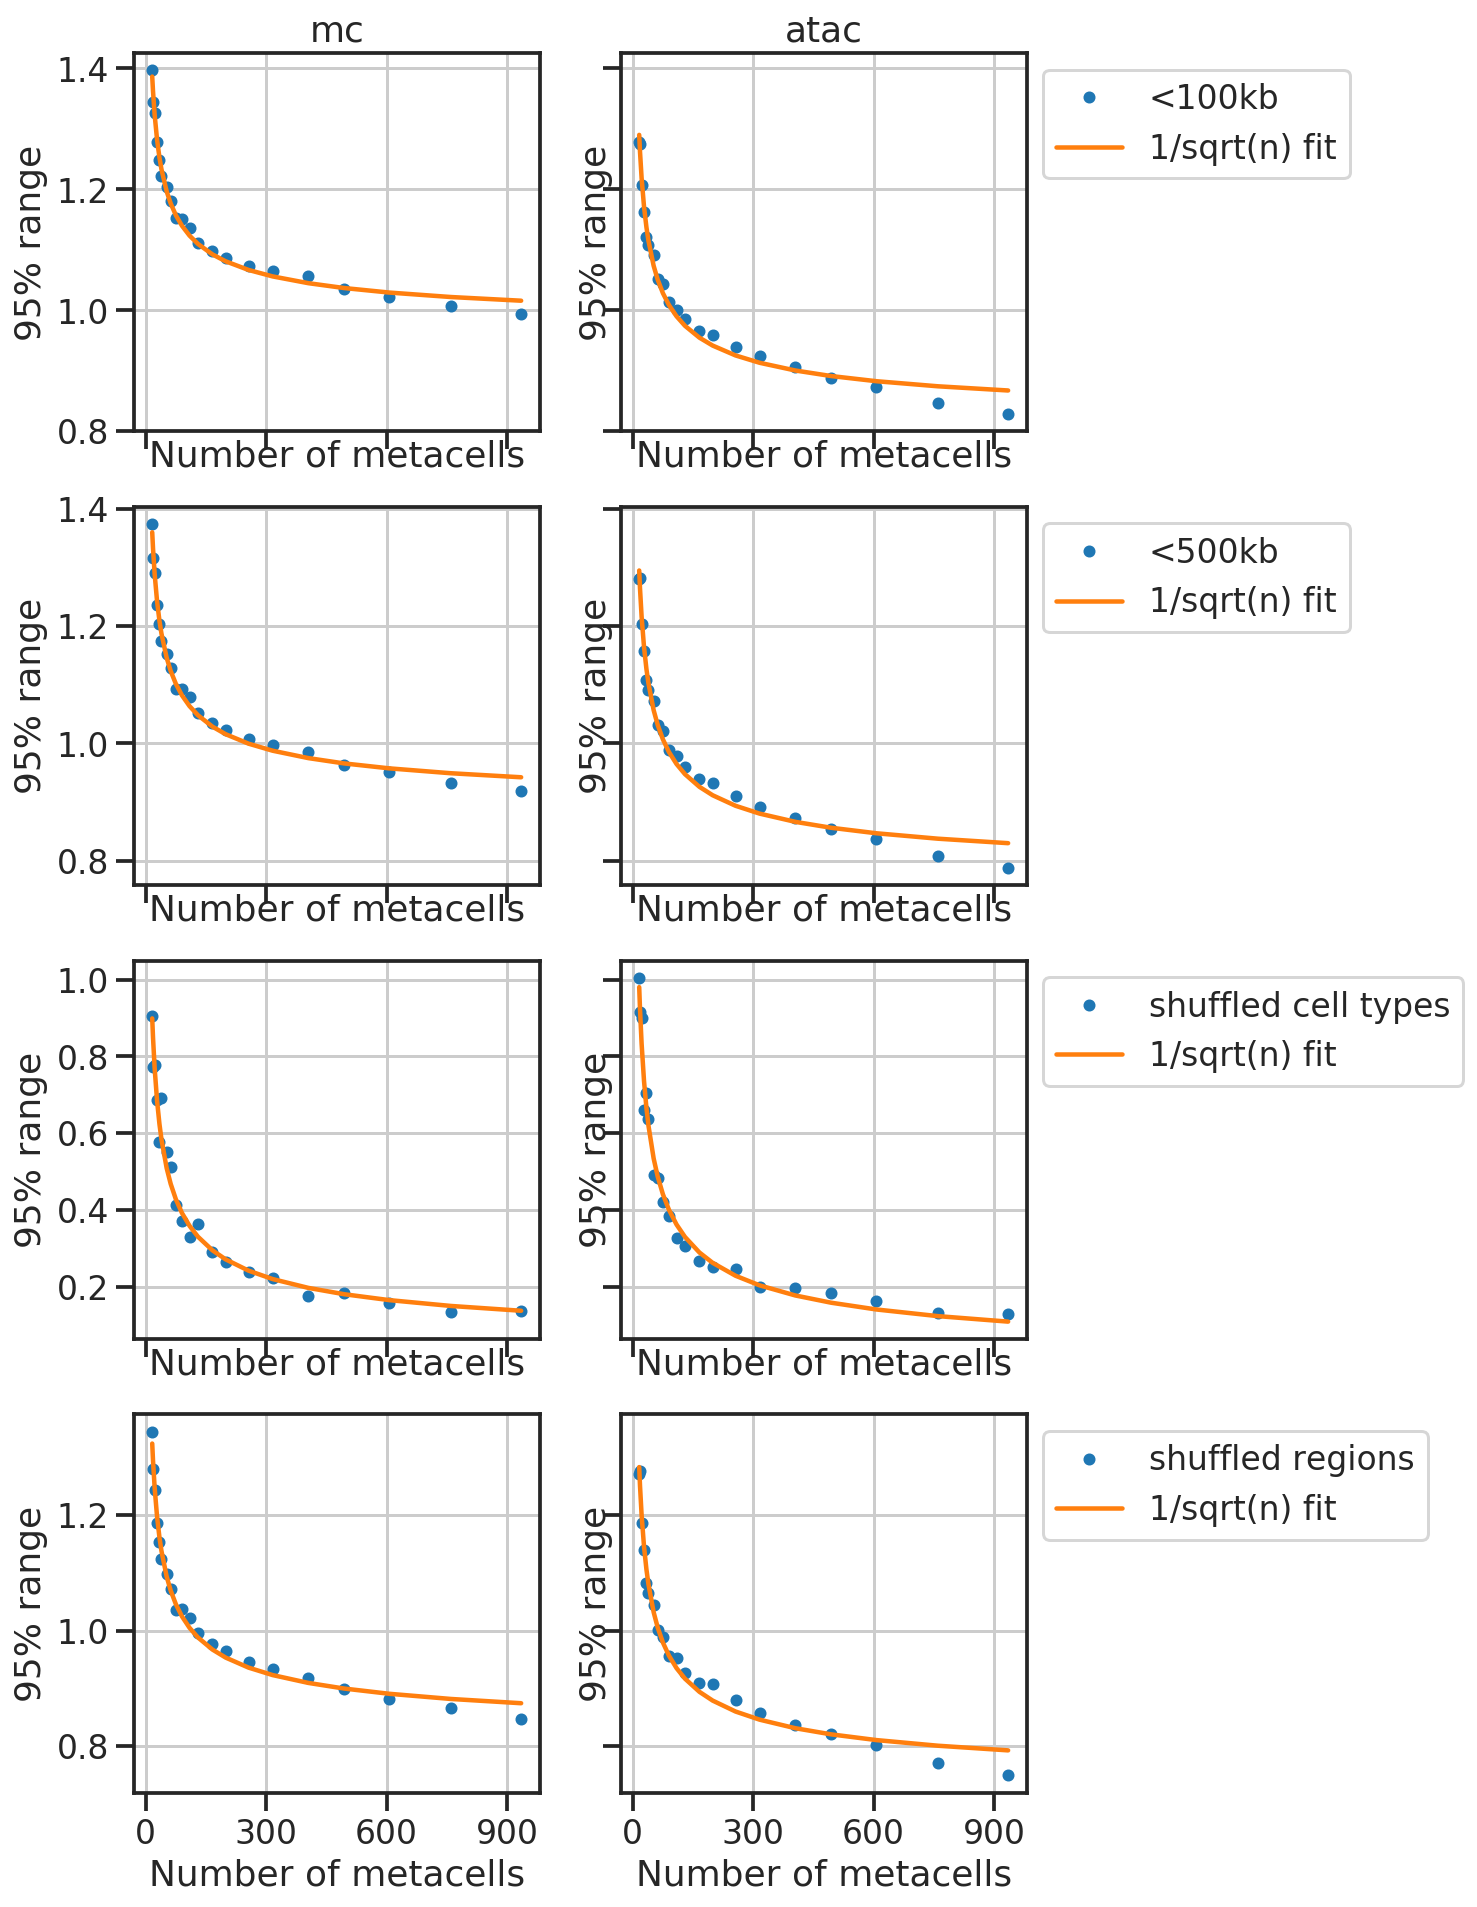

In [24]:
def fit_func_linear(x, alpha, sigma):
    return alpha*x + sigma


toplot = res_summary
# aranged by mod and track type
mods = toplot['mod'].unique()
track_names = np.sort(toplot['track_name'].unique())

ny = len(track_names)
nx = len(mods)
fig, axs = plt.subplots(ny, nx, figsize=(nx*4, ny*4), sharex=True, sharey='row')
for i, track_name in enumerate(track_names):    
    for j, mod in enumerate(mods):    
        ax = axs[i,j]
        if i == 0:
            ax.set_title(mod)
        toplot_sub = toplot[((toplot['mod']==mod) & (toplot['track_name']==track_name))]
        
        x, y = toplot_sub['num_clst'], toplot_sub['interval']
        paras, _ = optimize.curve_fit(fit_func_linear, 1/np.sqrt(x), y)
        yfit = fit_func_linear(1/np.sqrt(x), paras[0], paras[1])
        ax.plot(x, y, 'o', markersize=5, label=track_name)
        ax.plot(x, yfit, label='1/sqrt(n) fit')

        ax.set_xlabel('Number of metacells')
        ax.set_ylabel('95% range')
        
    ax.legend(bbox_to_anchor=(1,1), loc='upper left')
        
ax.xaxis.set_major_locator(plt.MaxNLocator(4))    
        
plt.show()


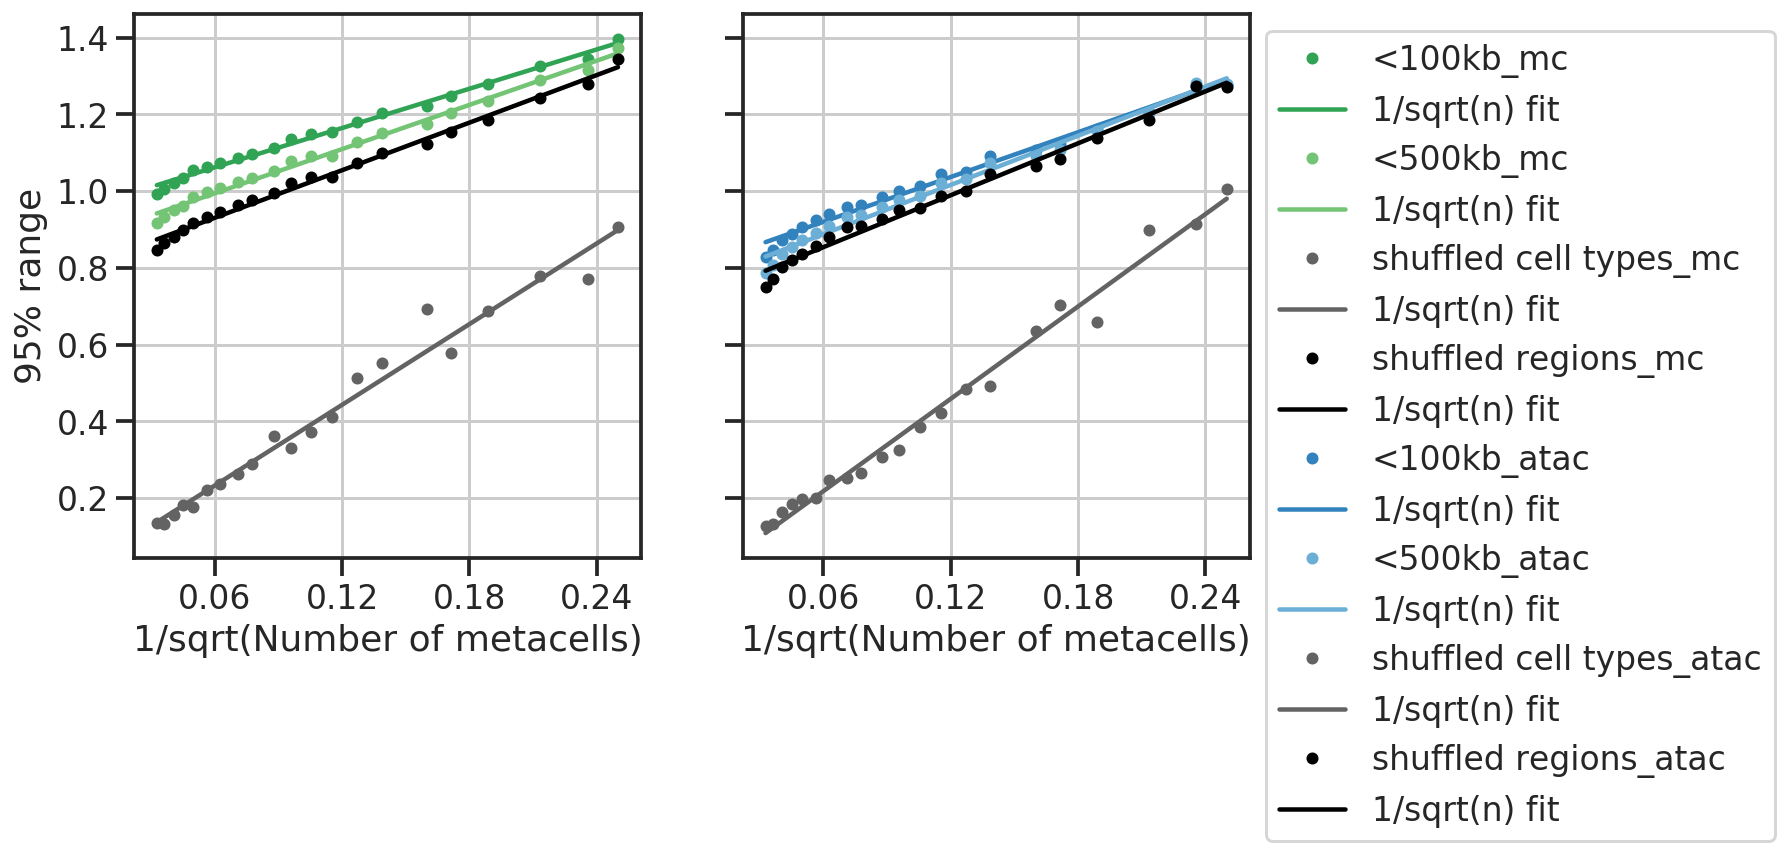

In [25]:
# plot the fitted results
def fit_func_linear(x, alpha, sigma):
    return alpha*x + sigma


toplot = res_summary
# aranged by mod and track type
mods = toplot['mod'].unique()
track_names = np.sort(toplot['track_name'].unique())

fig, axs = plt.subplots(1, 2, figsize=(5*2, 5), sharey=True, sharex=True)
for j, mod in enumerate(mods):    
    ax = axs[j]
    for i, track_name in enumerate(track_names):    
        label = track_name+'_'+mod
        color = track_color_palette[label]
        toplot_sub = toplot[((toplot['mod']==mod) & (toplot['track_name']==track_name))]
        
        x, y = toplot_sub['num_clst'], toplot_sub['interval']
        paras, _ = optimize.curve_fit(fit_func_linear, 1/np.sqrt(x), y)
        yfit = fit_func_linear(1/np.sqrt(x), paras[0], paras[1])
        
        ax.plot(1/np.sqrt(x), y, 'o', markersize=5, label=label, color=color)
        ax.plot(1/np.sqrt(x), yfit, label='1/sqrt(n) fit', color=color)

    ax.set_xlabel('1/sqrt(Number of metacells)')
    if j == 0:
        ax.set_ylabel('95% range')
        
ax.xaxis.set_major_locator(plt.MaxNLocator(4))    
handles, labels = snmcseq_utils.combine_legends(axs)
ax.legend(handles, labels, bbox_to_anchor=(1,1), loc='upper left')

plt.show()


# Todo 

- how this affect r correlated vs r linked
- how this affect num correlated vs num linked

- add arrow bar - 5 subsets
- do shuffle celltypes need to be done multiple times?
- work on the plots 